In [1]:
from collections import Counter
from google.colab import drive
from prettytable import PrettyTable

import math
import matplotlib.pyplot as plt
import numpy as np
import random
import statistics
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Experiments/context-projections-clustering

Mounted at /content/drive
/content/drive/MyDrive/Experiments/context-projections-clustering


# Model Class

In [4]:
from model import Model

# Functions

In [5]:
from utils2 import preprocess, cosine_similarity, orthogonal_projection_position, kmeans_cluster, get_context_projections, get_stats

# Read Text

In [6]:
with open('text8') as f:
    text = f.read()

words = preprocess(text)

print("Total words in text: %d" % (len(words)))
print("Unique words in text: %d" % (len(set(words))))

Total words in text: 8448361
Unique words in text: 63459


## Choosing Test Words

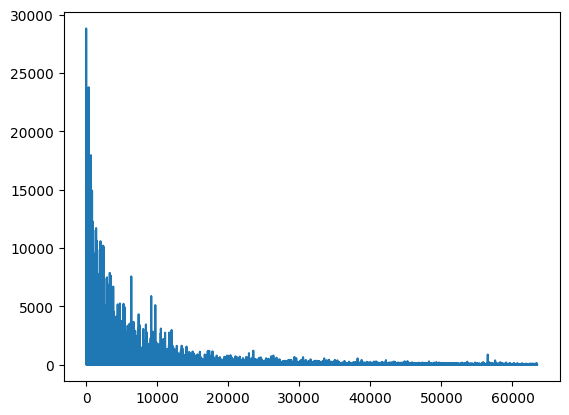

In [7]:
counter = Counter(words)
plt.plot(range(len(counter.keys())), counter.values())
plt.show()

In [8]:
num_samples = 50
test_indexes = np.random.choice(range(100, 20000), size=(num_samples))
test_words = [list(counter.keys())[i] for i in test_indexes]

print("Five of the picked test words: ", test_words[:5])

Five of the picked test words:  ['removes', 'lowland', 'accustomed', 'refuted', 'wetland']


In [9]:
test_dict = {x : {"pos" : list(), "neg" : list()} for x in test_words}
window_size = 3
neg_sample = 3

for idx, w in enumerate(words):
  if w in test_words:
    start , end = max(0 , idx-window_size) , min(len(words)-1 , idx+window_size) + 1
    ctx_samples = [s for s in words[start:idx] + words[idx+1:end] if s != w]
    test_dict[w]["pos"].extend(ctx_samples)
    neg_size = len(ctx_samples) * neg_sample
    test_dict[w]["neg"].extend(random.choices(words, k = neg_size))

nr_contexts , nr_noises = 100 , 100
test_dict = {key: {"pos" :  [i[0] for i in Counter(value["pos"]).most_common(nr_contexts)], "neg" : [i[0] for i in Counter(value["neg"]).most_common(nr_noises)]} for key, value in test_dict.items()}
print(list(test_dict.items())[0])

('removes', {'pos': ['cards', 'groups', 'water', 'data', 'hand', 'need', 'adds', 'player', 'new', 'world', 'material', 'real', 'sun', 'reaction', 'hydroxyl', 'alcohols', 'ambiguity', 'full', 'unless', 'otherwise', 'god', 'without', 'used', 'example', 'network', 'glycogen', 'residues', 'balls', 'group', 'always', 'rhyme', 'hydrogen', 'carbon', 'oxygen', 'activated', 'wishes', 'replace', 'discards', 'earth', 'incentive', 'case', 'called', 'possibility', 'judges', 'fortran', 'features', 'overlying', 'crust', 'way', 'account', 'kryptonite', 'posner', 'barton', 'reduction', 'carbonyl', 'aldehydes', 'omission', 'comma', 'taxes', 'politician', 'hopes', 'victims', 'families', 'principle', 'doubt', 'exact', 'nature', 'st', 'third', 'standard', 'stops', 'abbreviations', 'specified', 'arbitrariness', 'number', 'degree', 'hostile', 'reactions', 'gag', 'prisoner', 'mouth', 'lift', 'pull', 'away', 'bolt', 'pushing', 'rear', 'recognizes', 'abbreviation', 'reserving', 'period', 'somebody', 'cracks', '

# Models

In [10]:
with open('models/models.txt', 'r') as file:
    print(file.read())

base - Softplus for P(-) and P(+)
v15 - Dropout for input vectors
v18 - Only sigmoid for P(-), softplus+sigmoid for P(+)
v26 - Only negative loss, only sigmoid


In [11]:
versions = ["base", "v15", "v18", "v26"]
models = [[torch.load('models/%s/epoch_%d.torch' % (v, x), map_location=device) for x in range(0,7)] for v in versions]

# base

In [12]:
models1 = models[0]

## Stats

In [13]:
stats_table, stats_dict = get_stats(models1, test_dict)


[MODEL #0] Progress: 50/50
[MODEL #1] Progress: 50/50
[MODEL #2] Progress: 50/50
[MODEL #3] Progress: 50/50
[MODEL #4] Progress: 50/50
[MODEL #5] Progress: 50/50
[MODEL #6] Progress: 50/50

### Stats Dictionary
1. Average context (ctx repr.) projections on target (trg repr.)
2. Average noise (ctx repr.) projections on target (trg repr.)
3. Average ***variance*** of context (ctx repr.) projections on target (trg repr.)
4. Average projection **difference** of context (ctx repr.) and noise (ctx repr.) on target (trg repr.)
5. Average ***cos-similarity*** of context (trg repr.) and target (trg repr.)
6. Average target magnitude

In [14]:
print(stats_table)

+--------------+--------+--------+-------+-------+-------+--------+
|    Target    |   1    |   2    |   3   |   4   |   5   |   6    |
+--------------+--------+--------+-------+-------+-------+--------+
|   removes    | 0.003  | -0.051 | 0.006 | 0.054 | 0.096 | 19.578 |
|   lowland    | 0.144  | 0.016  | 0.011 | 0.128 | 0.184 | 19.088 |
|  accustomed  | -0.081 | -0.115 | 0.003 | 0.034 | 0.022 | 18.797 |
|   refuted    | -0.018 | -0.080 | 0.006 | 0.062 | 0.081 | 18.887 |
|   wetland    | 0.099  | -0.037 | 0.016 | 0.137 | 0.119 | 14.608 |
|    wrong     | -0.093 | -0.182 | 0.004 | 0.089 | 0.096 | 20.791 |
|  scattering  | 0.030  | -0.088 | 0.011 | 0.119 | 0.159 | 19.161 |
|  purifying   | 0.093  | 0.005  | 0.012 | 0.089 | 0.090 | 14.552 |
|  diaphragm   | 0.172  | 0.007  | 0.014 | 0.165 | 0.172 | 15.704 |
|    coded     | 0.069  | -0.013 | 0.005 | 0.082 | 0.138 | 20.031 |
|    highs     | 0.141  | 0.030  | 0.014 | 0.111 | 0.085 | 15.743 |
|    tokyo     | 0.155  | 0.073  | 0.007 | 0.082

In [15]:
for model_idx, values in stats_dict.items():
  print("EPOCH #%d [1: %.3f] [2: %.3f] [3: %.3f] [4: %.3f] [5: %.3f] [6: %.3f] " % (model_idx, values["avg_proj_1"], values["avg_noise_proj"], values["var_proj_1"], values["avg_proj_2"], values["avg_sim"], values["avg_mag"]))

EPOCH #0 [1: 0.001] [2: -0.000] [3: 0.003] [4: 0.001] [5: -0.002] [6: 10.011] 
EPOCH #1 [1: 0.022] [2: -0.044] [3: 0.006] [4: 0.066] [5: 0.059] [6: 11.574] 
EPOCH #2 [1: 0.046] [2: -0.045] [3: 0.009] [4: 0.091] [5: 0.095] [6: 12.982] 
EPOCH #3 [1: 0.049] [2: -0.047] [3: 0.010] [4: 0.096] [5: 0.106] [6: 14.303] 
EPOCH #4 [1: 0.062] [2: -0.035] [3: 0.010] [4: 0.097] [5: 0.109] [6: 15.538] 
EPOCH #5 [1: 0.069] [2: -0.027] [3: 0.010] [4: 0.096] [5: 0.109] [6: 16.709] 
EPOCH #6 [1: 0.073] [2: -0.022] [3: 0.010] [4: 0.095] [5: 0.109] [6: 17.861] 


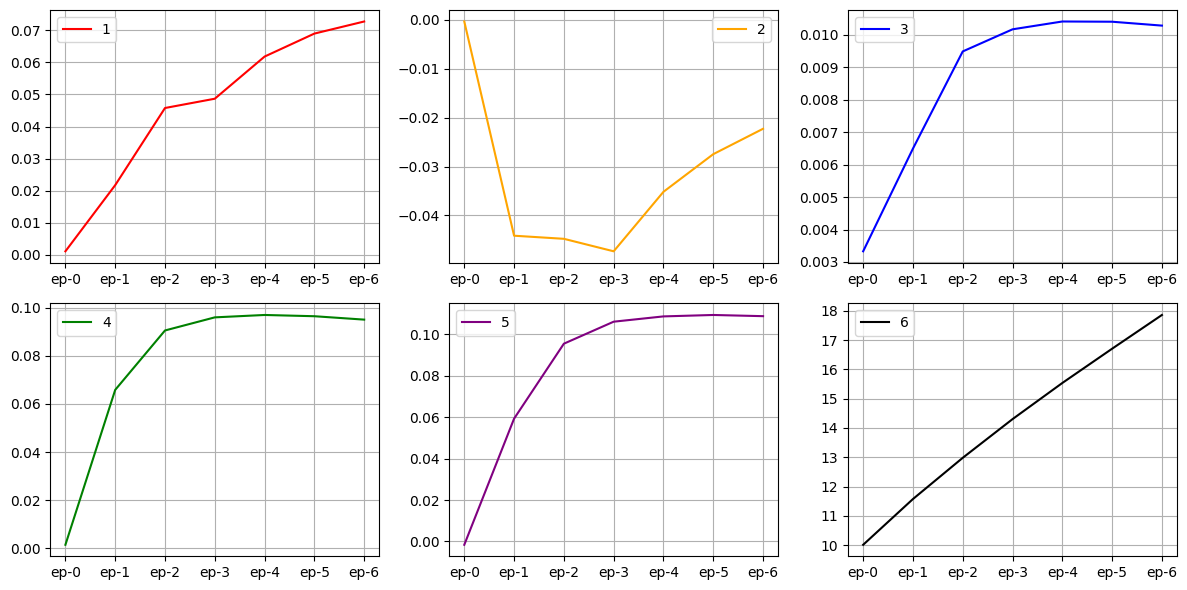

In [16]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_1"] for v in stats_dict.values()], label = "1", color="red")
ax1.legend()

ax2.grid(axis='both')
ax2.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_noise_proj"] for v in stats_dict.values()], label = "2", color="orange")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%x for x in stats_dict.keys()], [v["var_proj_1"] for v in stats_dict.values()], label = "3", color="blue")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_2"] for v in stats_dict.values()], label = "4", color="green")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_sim"] for v in stats_dict.values()], label = "5", color="purple")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_mag"] for v in stats_dict.values()], label = "6", color="black")
ax6.legend()

fig.tight_layout()
fig.show()

# Visualize distributions

In [17]:
test_indexes = range(0, 20)

targets = [list(test_dict.keys())[test_index] for test_index in test_indexes]

print("Visuaizing for: ", targets)

Visuaizing for:  ['removes', 'lowland', 'accustomed', 'refuted', 'wetland', 'wrong', 'scattering', 'purifying', 'diaphragm', 'coded', 'highs', 'tokyo', 'evaluated', 'terrified', 'noma', 'retracted', 'reducing', 'reversed', 'nexus', 'iaea']


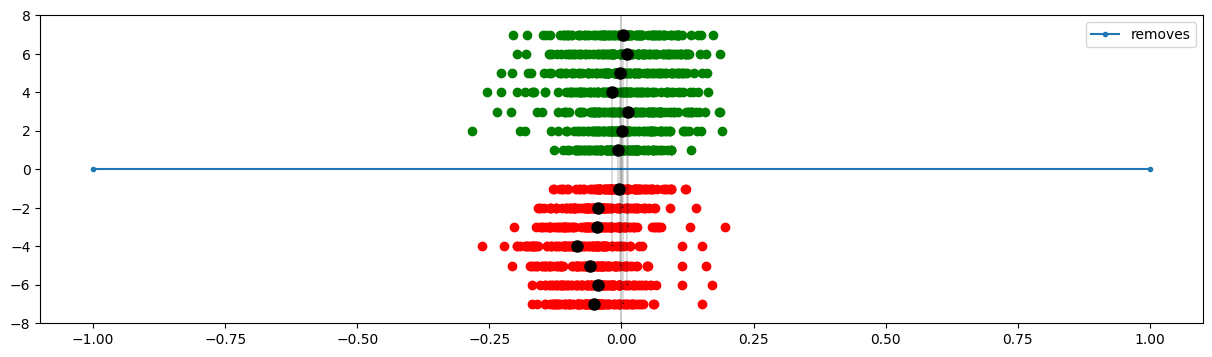

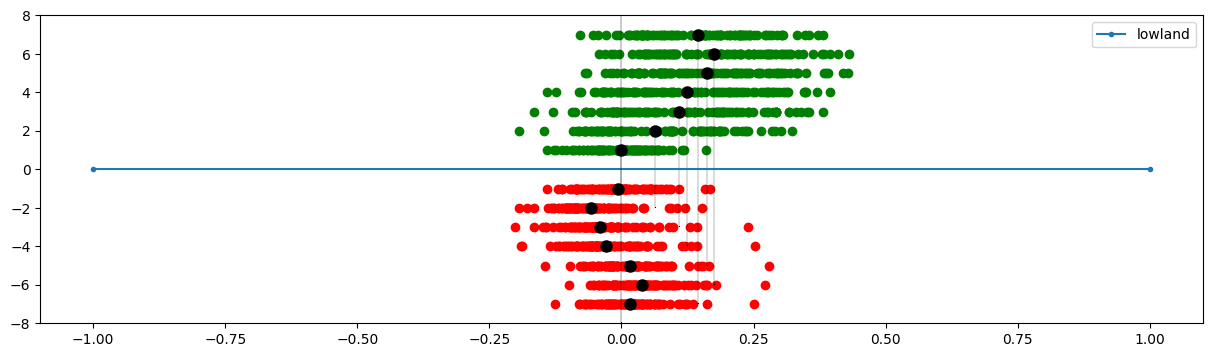

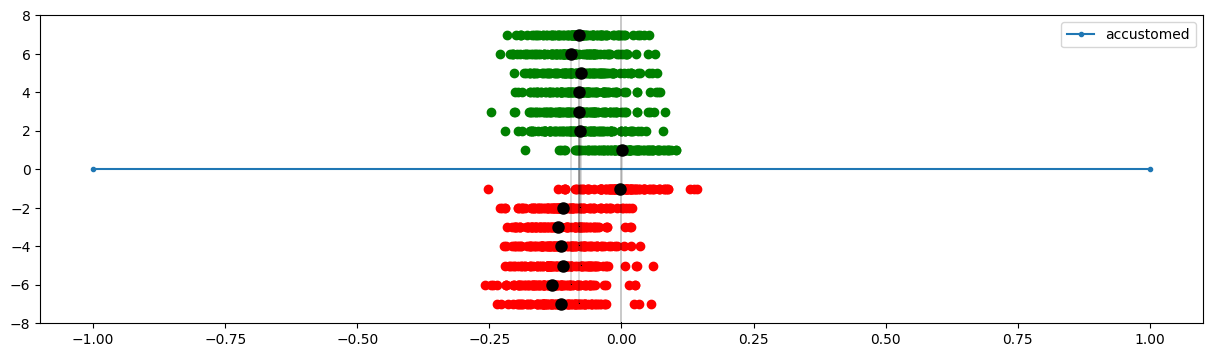

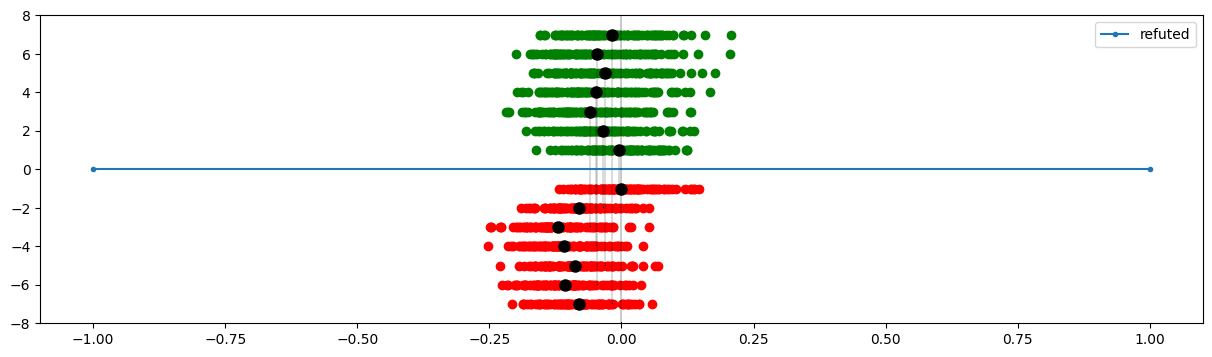

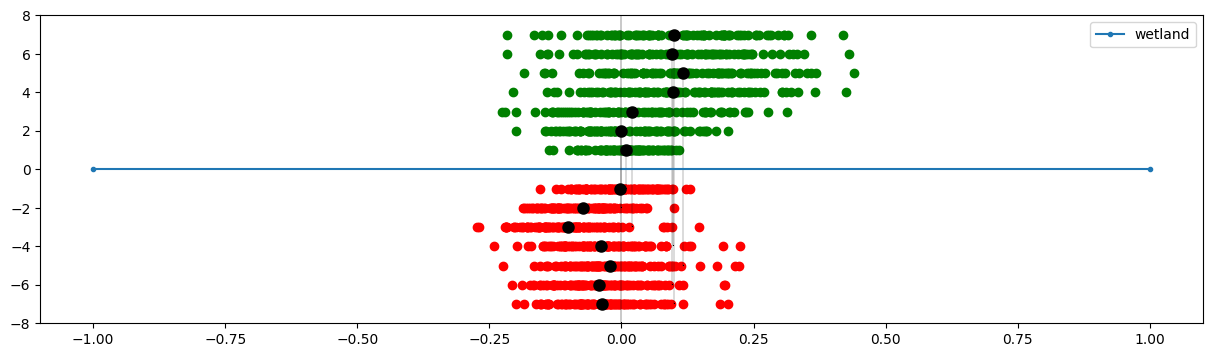

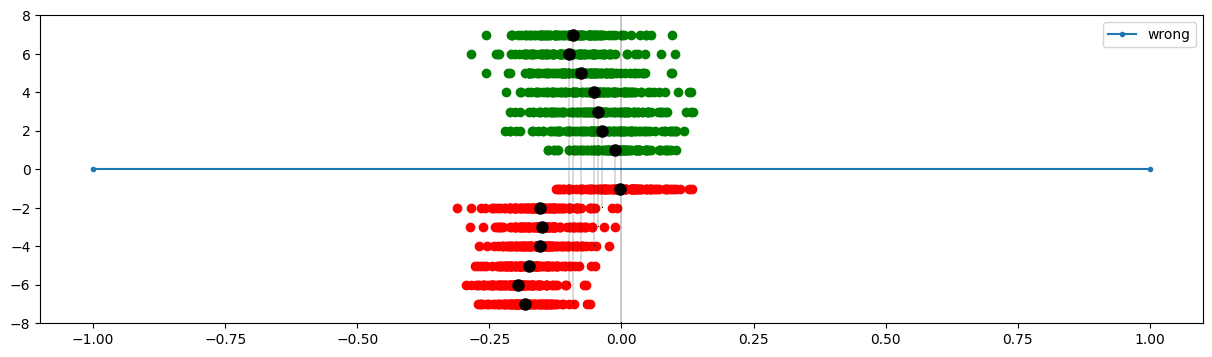

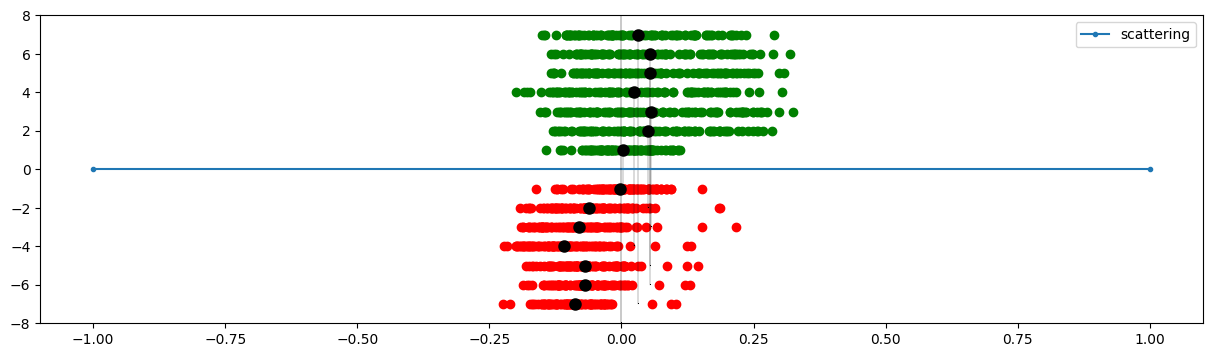

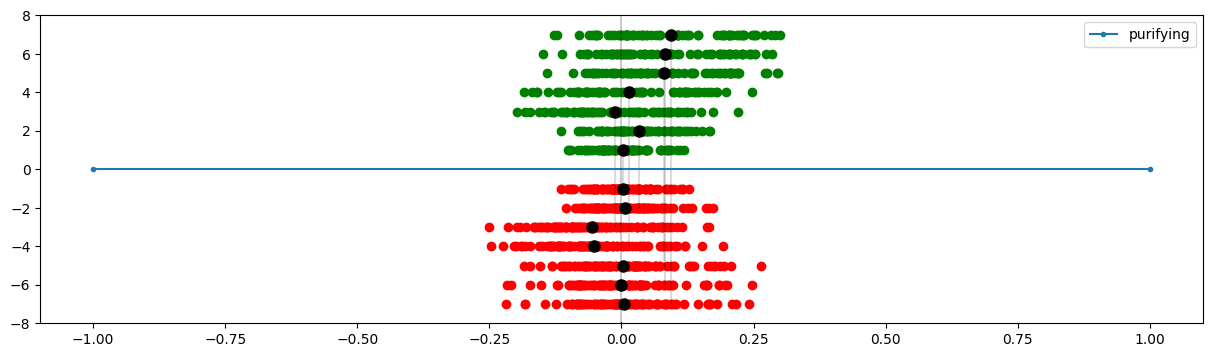

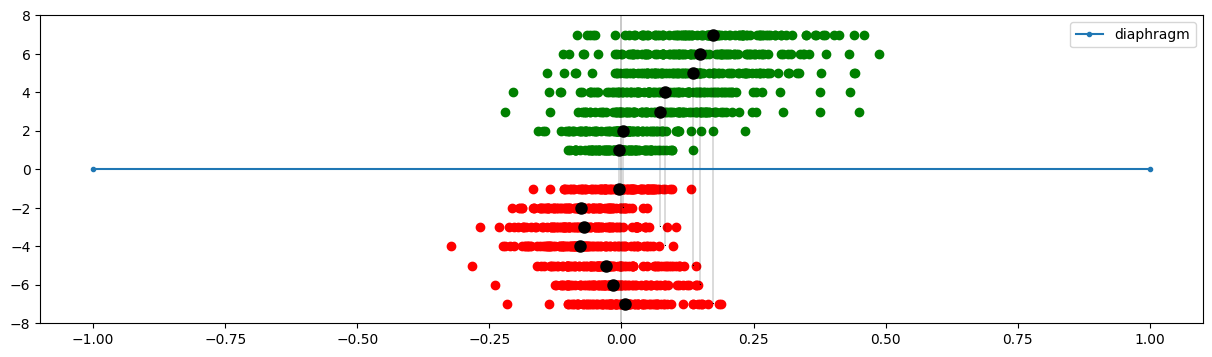

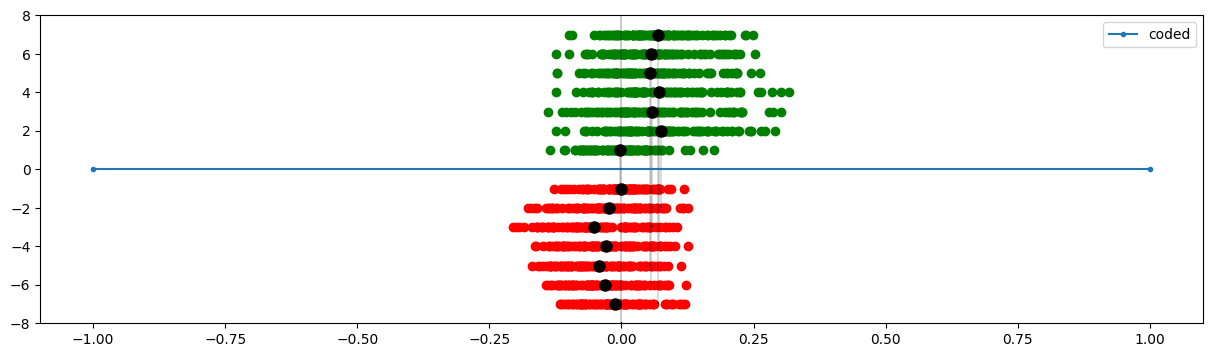

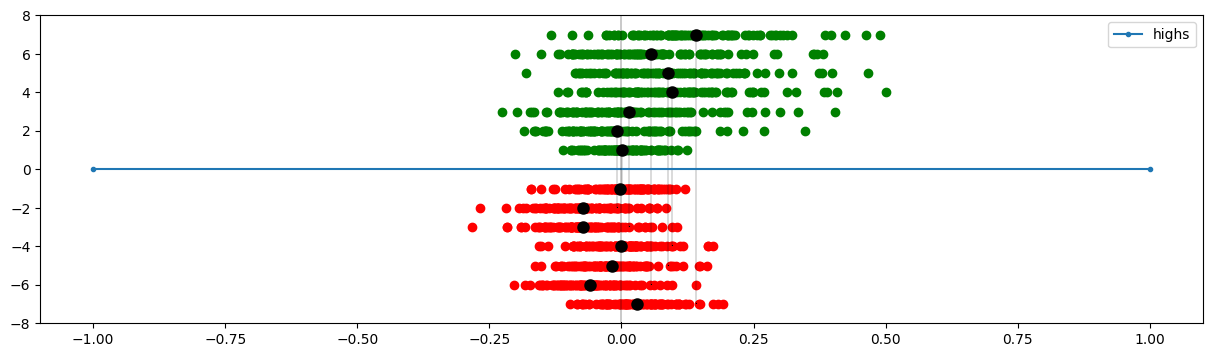

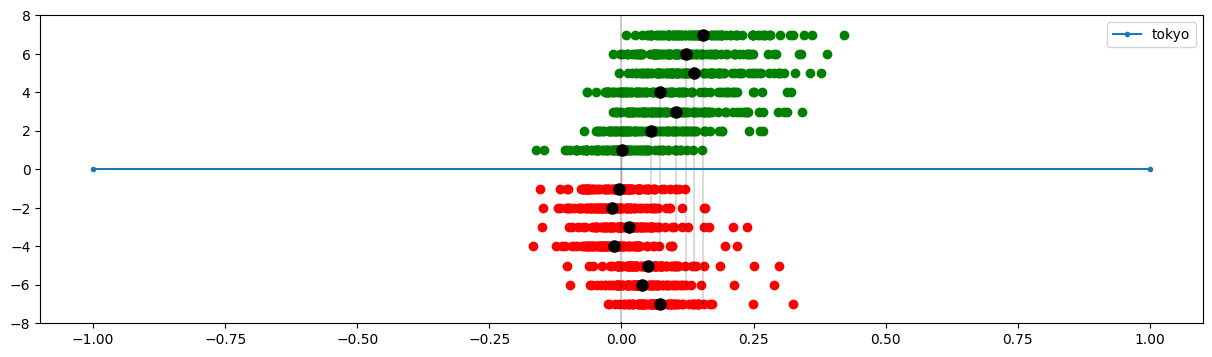

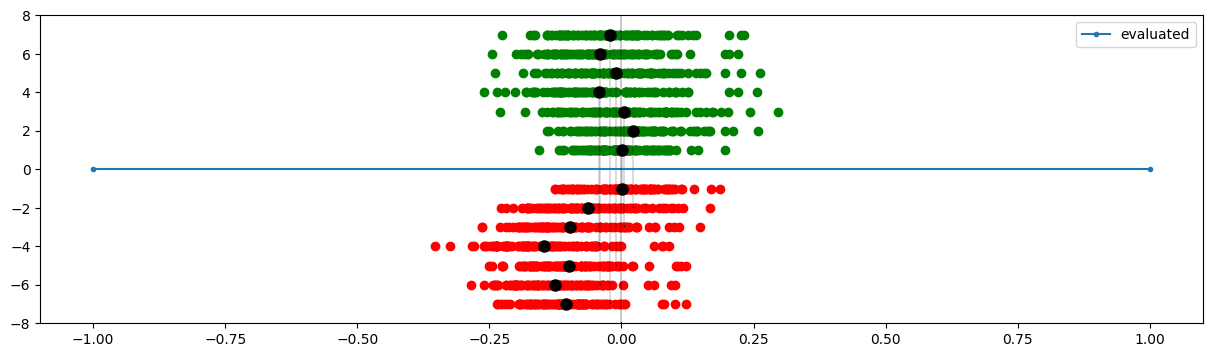

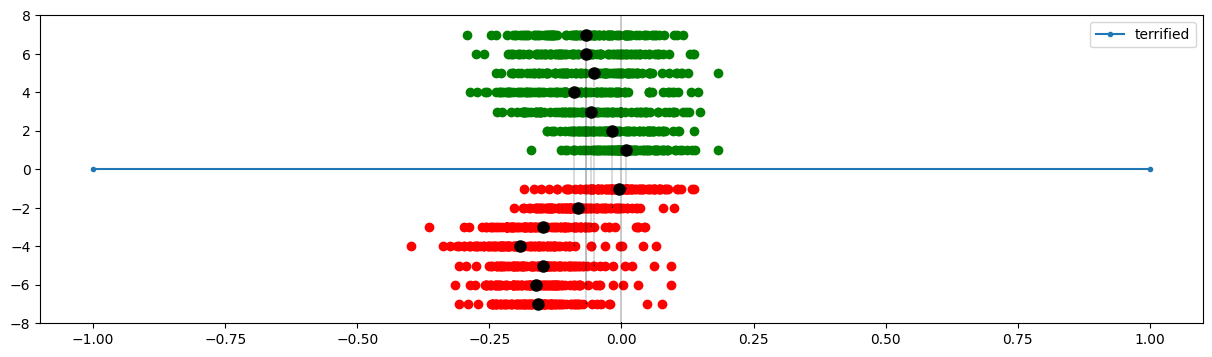

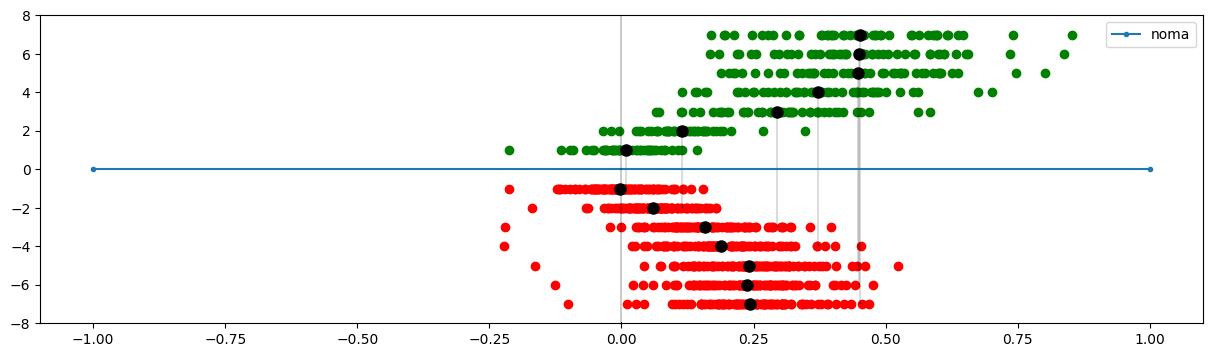

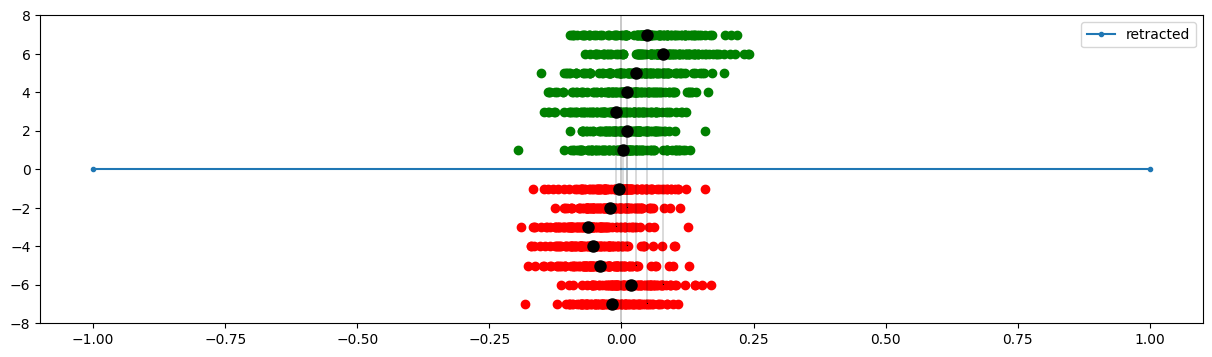

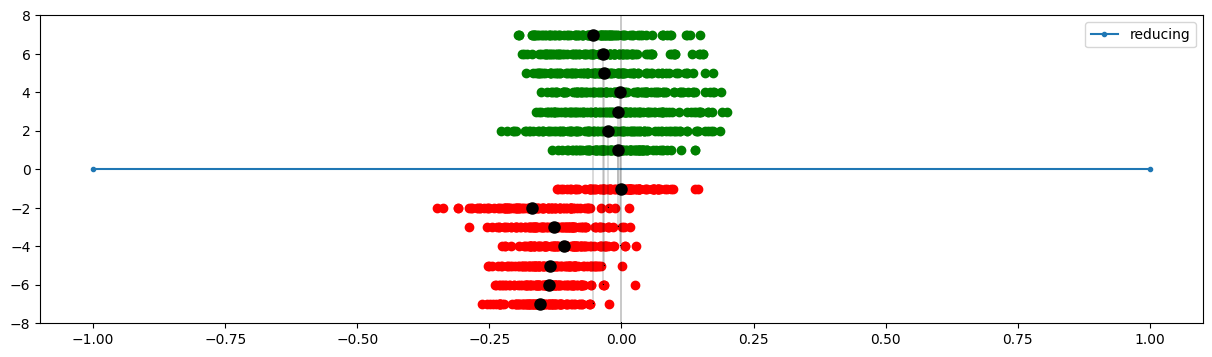

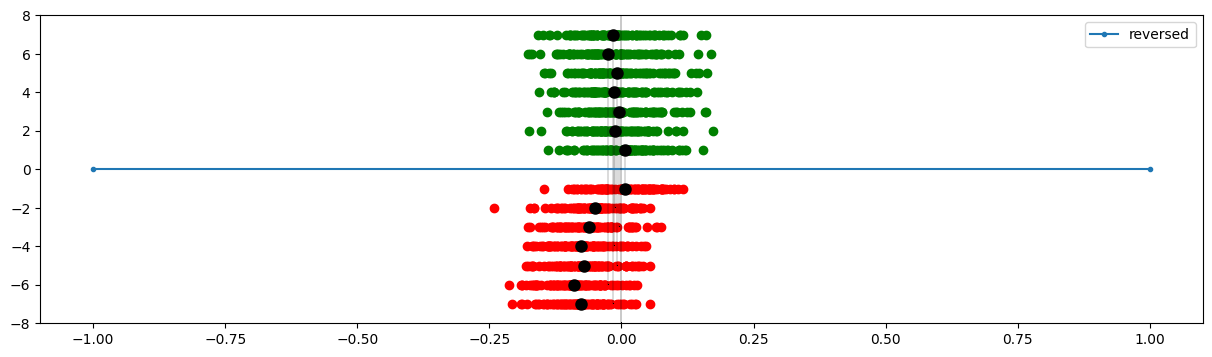

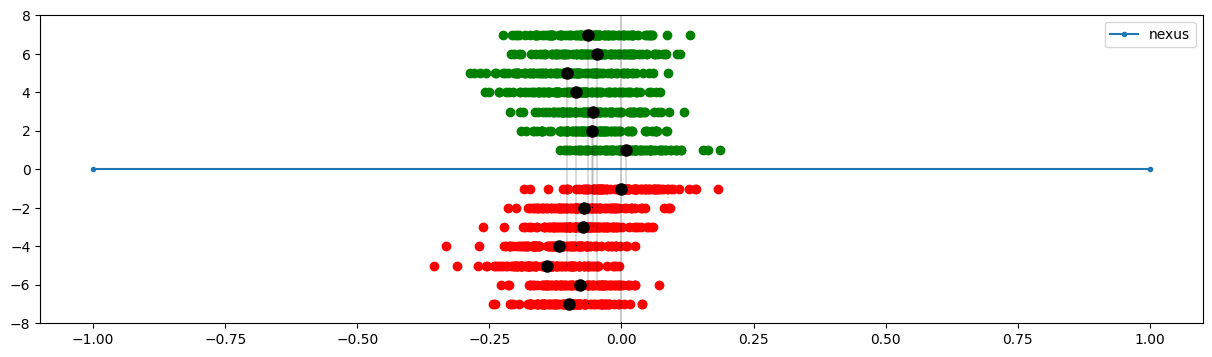

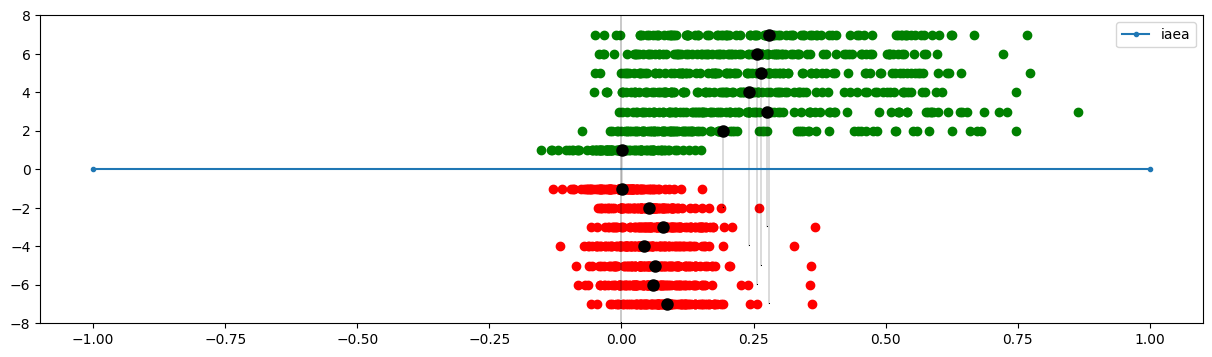

In [18]:
for trg in targets:
  contexts = test_dict[trg]["pos"]
  noises = test_dict[trg]["neg"]

  plt.figure(figsize=(15,4))

  for epoch in range(len(models1)):
    target_vectors = models1[epoch].embedding_input_dictionary()
    context_vectors = models1[epoch].embedding_output_dictionary()

    context_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in contexts]
    noise_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in noises]

    plt.scatter(context_projections, [epoch+1] * len(context_projections), color="green")
    plt.scatter([statistics.mean(context_projections)], [epoch+1], color="black", linewidths=3.0)
    x1, y1 = [statistics.mean(context_projections), statistics.mean(context_projections)], [-(epoch+1), (epoch+1)]
    plt.plot(x1, y1, marker = ',', color="black", linewidth=0.2)

    plt.scatter(noise_projections, [-(epoch+1)] * len(noise_projections), color="red")
    plt.scatter([statistics.mean(noise_projections)], [-(epoch+1)], color="black", linewidths=3.0)

  #magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
  magnitude = 1.0
  x1, y1 = [-magnitude, +magnitude], [0, 0]
  plt.plot(x1, y1, marker = '.', label=trg)

  x1, y1 = [0, 0], [-(epoch+2), (epoch+2)]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

  plt.legend()
  plt.ylim((-(epoch+2), (epoch+2)))
  plt.show()

## Clustering projections

In [19]:
cluster_dict = {model_idx: {i:0 for i in range(2,9)} for model_idx in range(len(models1))}
ideal_cluster_dict = {word:[0, 0, list()] for word in test_dict.keys()}

for model_idx in range(len(models1)):

  trg_emb = models1[model_idx].embedding_input_dictionary()
  ctx_emb = models1[model_idx].embedding_output_dictionary()
  counter = 0
  print()

  for word, samples in test_dict.items():

    contexts = samples["pos"]

    ideal_cluster_dict[word][1] = 0
    ideal_cluster_dict[word][0] = 0

    for k in range(2,9):

      score, cluster_indices = kmeans_cluster(k, [orthogonal_projection_position(word, ctx, trg_emb, ctx_emb) for ctx in contexts])
      #clusters = [[contexts[idx] for idx in cluster] for cluster in cluster_indices.values()]

      cluster_dict[model_idx][k] = cluster_dict[model_idx][k] + (score / len(test_dict.items()))

      if ideal_cluster_dict[word][1] < score:
        ideal_cluster_dict[word][1] = score
        ideal_cluster_dict[word][0] = k
    ideal_cluster_dict[word][2].append((ideal_cluster_dict[word][0], ideal_cluster_dict[word][1]))

    counter += 1
    print("\r[MODEL #%d] Progress: %d/%d" % (model_idx, counter, len(test_dict.items())), end='')

  print("\n", cluster_dict[model_idx])


[MODEL #0] Progress: 50/50
 {2: 0.56273207716401, 3: 0.548796103003911, 4: 0.5462564593172061, 5: 0.5549147140381727, 6: 0.5583220352658942, 7: 0.5573116454616036, 8: 0.5526803835607554}

[MODEL #1] Progress: 50/50
 {2: 0.5717836530156313, 3: 0.5650949658535013, 4: 0.5510502804624205, 5: 0.5449100546662031, 6: 0.5512301244000798, 7: 0.5593935609876173, 8: 0.5613871549561131}

[MODEL #2] Progress: 50/50
 {2: 0.5898524049272084, 3: 0.5603113370556313, 4: 0.5483797039613909, 5: 0.5545642327647851, 6: 0.5566424180723696, 7: 0.5581409301209146, 8: 0.5629708072756353}

[MODEL #3] Progress: 50/50
 {2: 0.5873154163662971, 3: 0.5607157931929608, 4: 0.5577029128879856, 5: 0.5534226692587308, 6: 0.5473470897156375, 7: 0.540203863473276, 8: 0.5587369581380652}

[MODEL #4] Progress: 50/50
 {2: 0.5895270039963802, 3: 0.5591991549971009, 4: 0.551565506123855, 5: 0.5462785729057626, 6: 0.5492180917058603, 7: 0.5529240463889133, 8: 0.5665748147525764}

[MODEL #5] Progress: 50/50
 {2: 0.583142321961744

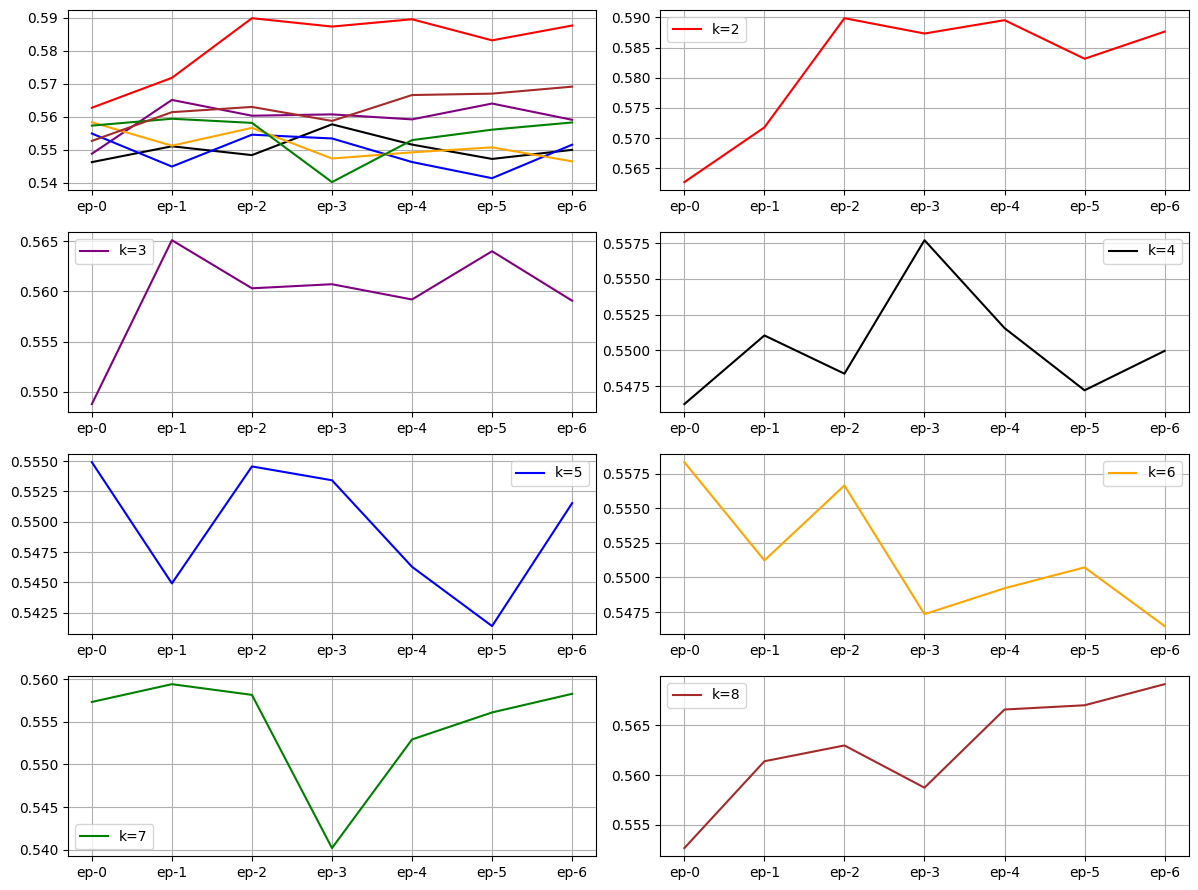

In [20]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 9))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")

ax2.grid(axis='both')
ax2.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax6.legend()

ax7.grid(axis='both')
ax7.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax7.legend()

ax8.grid(axis='both')
ax8.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")
ax8.legend()


fig.tight_layout()
fig.show()

In [21]:
cluster_table = PrettyTable()
cluster_table.field_names = ["Target", "Ideal Nr of Clusters per Epoch", "Score"]
for word in test_dict.keys():
  cluster_table.add_row([word, [x[0] for x in ideal_cluster_dict[word][2]], ["%.3f"%x[1] for x in ideal_cluster_dict[word][2]]])

print(cluster_table)

+--------------+--------------------------------+-----------------------------------------------------------------+
|    Target    | Ideal Nr of Clusters per Epoch |                              Score                              |
+--------------+--------------------------------+-----------------------------------------------------------------+
|   removes    |     [4, 3, 8, 8, 3, 3, 3]      | ['0.601', '0.591', '0.572', '0.566', '0.575', '0.575', '0.564'] |
|   lowland    |     [2, 2, 2, 2, 2, 2, 8]      | ['0.581', '0.641', '0.647', '0.621', '0.625', '0.609', '0.616'] |
|  accustomed  |     [2, 3, 2, 5, 8, 4, 8]      | ['0.557', '0.567', '0.562', '0.571', '0.568', '0.604', '0.578'] |
|   refuted    |     [2, 8, 2, 2, 2, 2, 2]      | ['0.607', '0.556', '0.600', '0.601', '0.629', '0.613', '0.600'] |
|   wetland    |     [8, 2, 2, 2, 7, 2, 2]      | ['0.581', '0.645', '0.579', '0.587', '0.598', '0.577', '0.586'] |
|    wrong     |     [7, 5, 3, 2, 8, 8, 3]      | ['0.621', '0.579', '0.

# v15

In [22]:
models2 = models[1]

## Stats

In [23]:
stats_table, stats_dict = get_stats(models2, test_dict)


[MODEL #0] Progress: 50/50
[MODEL #1] Progress: 50/50
[MODEL #2] Progress: 50/50
[MODEL #3] Progress: 50/50
[MODEL #4] Progress: 50/50
[MODEL #5] Progress: 50/50
[MODEL #6] Progress: 50/50

### Stats Dictionary
1. Average context (ctx repr.) projections on target (trg repr.)
2. Average noise (ctx repr.) projections on target (trg repr.)
3. Average ***variance*** of context (ctx repr.) projections on target (trg repr.)
4. Average projection **difference** of context (ctx repr.) and noise (ctx repr.) on target (trg repr.)
5. Average ***cos-similarity*** of context (trg repr.) and target (trg repr.)
6. Average target magnitude

In [24]:
print(stats_table)

+--------------+--------+--------+-------+-------+-------+--------+
|    Target    |   1    |   2    |   3   |   4   |   5   |   6    |
+--------------+--------+--------+-------+-------+-------+--------+
|   removes    | -0.015 | -0.090 | 0.006 | 0.075 | 0.110 | 19.634 |
|   lowland    | 0.242  | 0.106  | 0.012 | 0.136 | 0.226 | 19.248 |
|  accustomed  | -0.192 | -0.239 | 0.004 | 0.048 | 0.044 | 19.017 |
|   refuted    | -0.036 | -0.106 | 0.007 | 0.071 | 0.106 | 18.196 |
|   wetland    | 0.160  | 0.019  | 0.016 | 0.140 | 0.149 | 14.981 |
|    wrong     | -0.164 | -0.261 | 0.004 | 0.098 | 0.121 | 20.870 |
|  scattering  | -0.007 | -0.137 | 0.017 | 0.130 | 0.180 | 19.181 |
|  purifying   | -0.027 | -0.109 | 0.011 | 0.082 | 0.106 | 15.303 |
|  diaphragm   | 0.204  | 0.035  | 0.015 | 0.169 | 0.203 | 16.083 |
|    coded     | 0.065  | -0.020 | 0.009 | 0.086 | 0.155 | 19.407 |
|    highs     | -0.046 | -0.157 | 0.015 | 0.110 | 0.105 | 16.327 |
|    tokyo     | 0.162  | 0.069  | 0.009 | 0.093

In [25]:
for model_idx, values in stats_dict.items():
  print("EPOCH #%d [1: %.3f] [2: %.3f] [3: %.3f] [4: %.3f] [5: %.3f] [6: %.3f] " % (model_idx, values["avg_proj_1"], values["avg_noise_proj"], values["var_proj_1"], values["avg_proj_2"], values["avg_sim"], values["avg_mag"]))

EPOCH #0 [1: 0.001] [2: -0.000] [3: 0.003] [4: 0.001] [5: -0.002] [6: 10.011] 
EPOCH #1 [1: 0.014] [2: -0.058] [3: 0.007] [4: 0.072] [5: 0.066] [6: 11.558] 
EPOCH #2 [1: 0.035] [2: -0.068] [3: 0.012] [4: 0.103] [5: 0.115] [6: 12.989] 
EPOCH #3 [1: 0.047] [2: -0.062] [3: 0.013] [4: 0.109] [5: 0.129] [6: 14.330] 
EPOCH #4 [1: 0.047] [2: -0.062] [3: 0.012] [4: 0.109] [5: 0.133] [6: 15.652] 
EPOCH #5 [1: 0.052] [2: -0.056] [3: 0.012] [4: 0.108] [5: 0.134] [6: 16.869] 
EPOCH #6 [1: 0.050] [2: -0.055] [3: 0.011] [4: 0.106] [5: 0.133] [6: 18.037] 


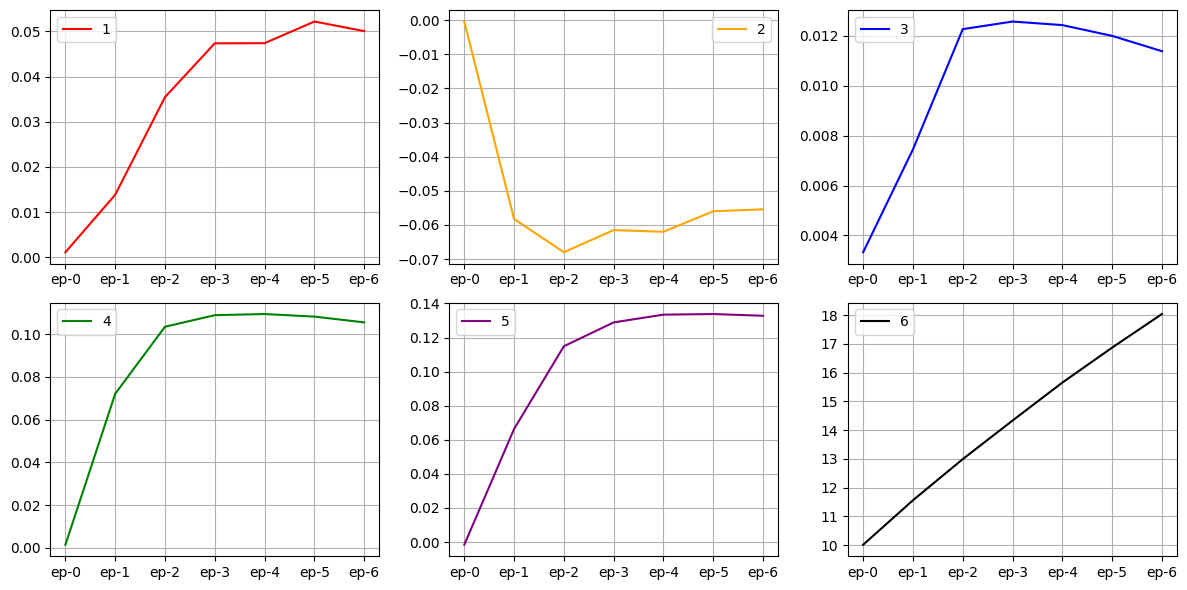

In [26]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_1"] for v in stats_dict.values()], label = "1", color="red")
ax1.legend()

ax2.grid(axis='both')
ax2.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_noise_proj"] for v in stats_dict.values()], label = "2", color="orange")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%x for x in stats_dict.keys()], [v["var_proj_1"] for v in stats_dict.values()], label = "3", color="blue")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_2"] for v in stats_dict.values()], label = "4", color="green")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_sim"] for v in stats_dict.values()], label = "5", color="purple")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_mag"] for v in stats_dict.values()], label = "6", color="black")
ax6.legend()

fig.tight_layout()
fig.show()

# Visualize distributions

In [27]:
test_indexes = range(0, 20)

targets = [list(test_dict.keys())[test_index] for test_index in test_indexes]

print("Visuaizing for: ", targets)

Visuaizing for:  ['removes', 'lowland', 'accustomed', 'refuted', 'wetland', 'wrong', 'scattering', 'purifying', 'diaphragm', 'coded', 'highs', 'tokyo', 'evaluated', 'terrified', 'noma', 'retracted', 'reducing', 'reversed', 'nexus', 'iaea']


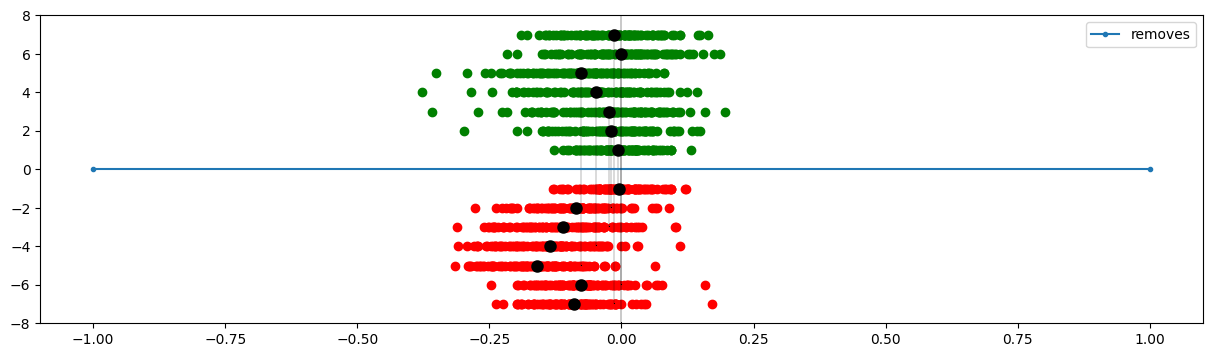

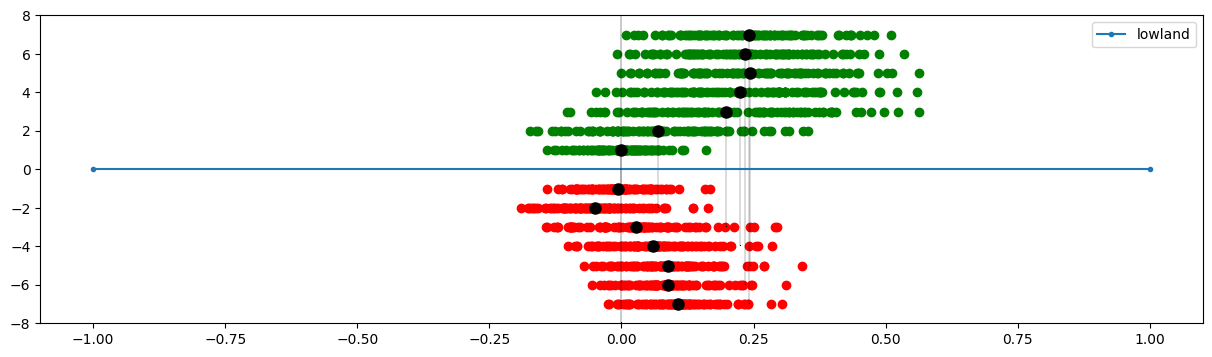

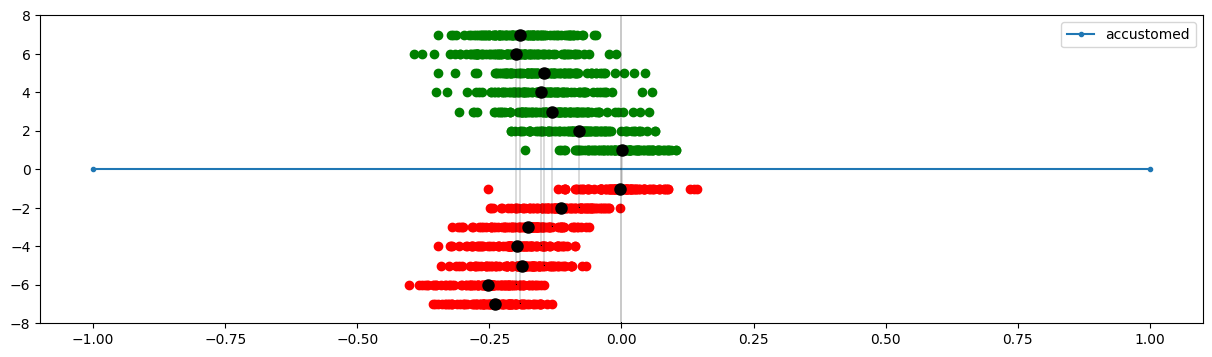

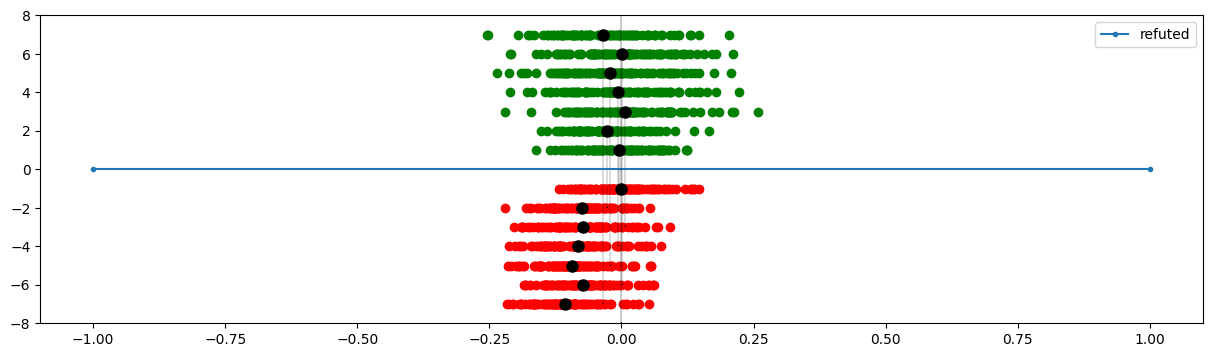

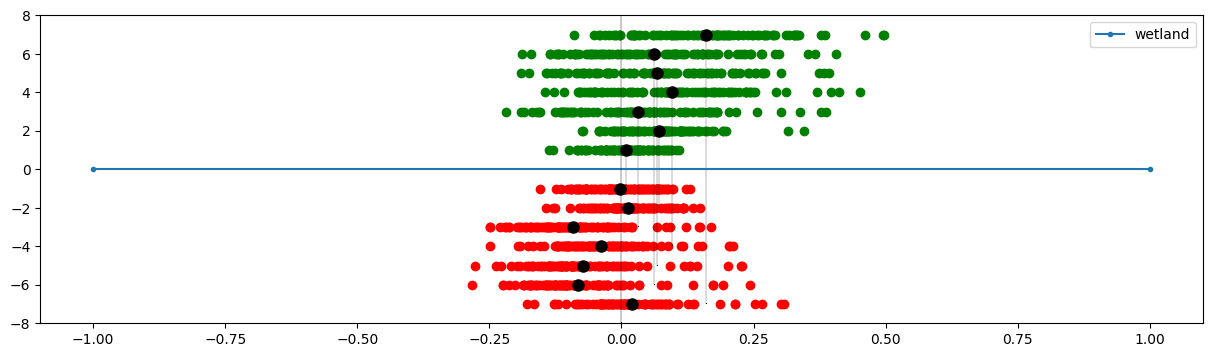

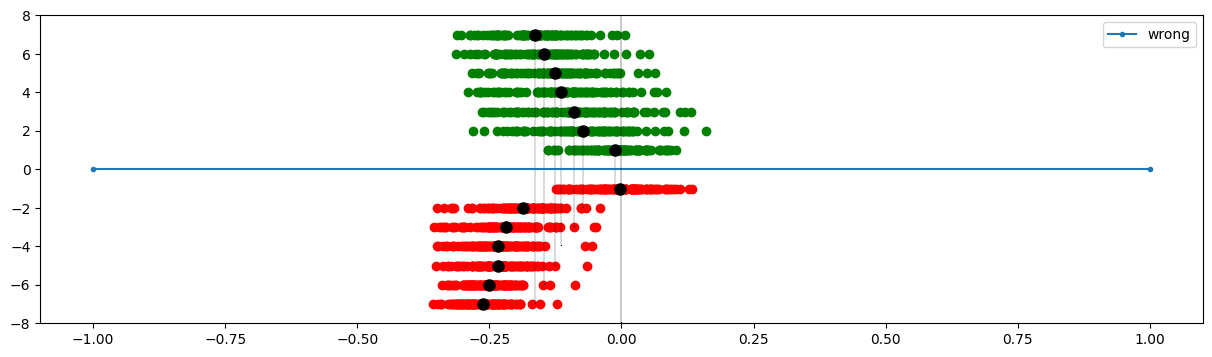

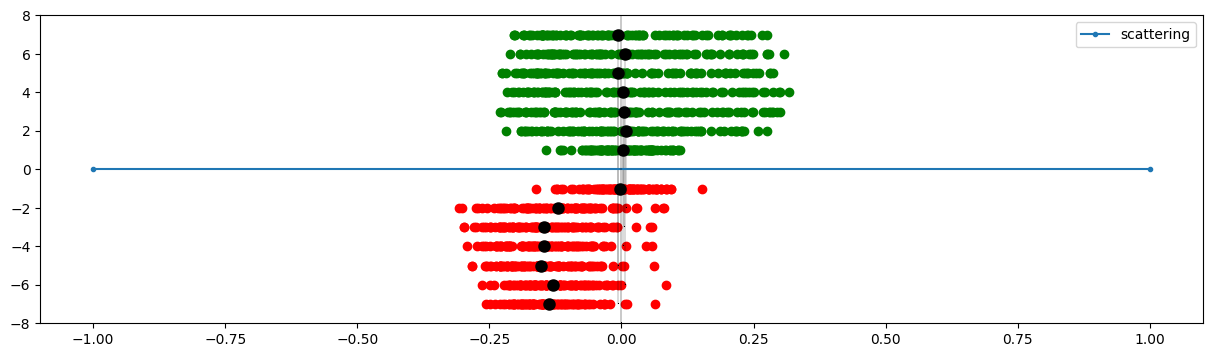

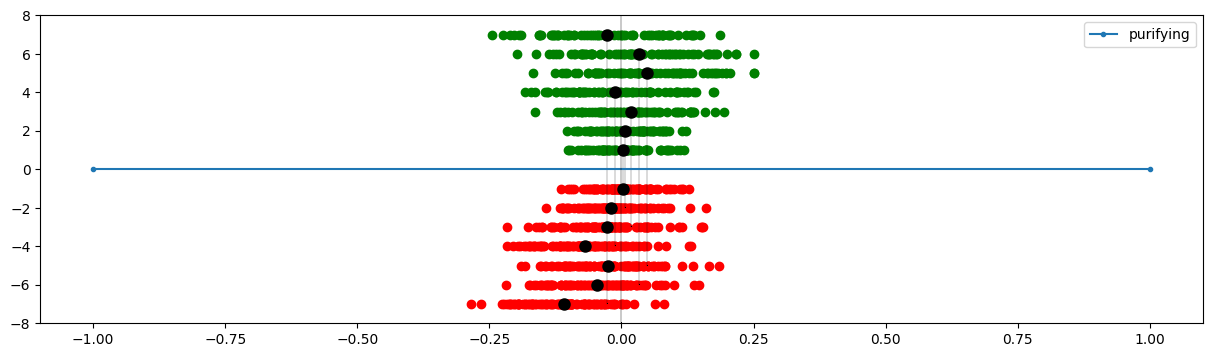

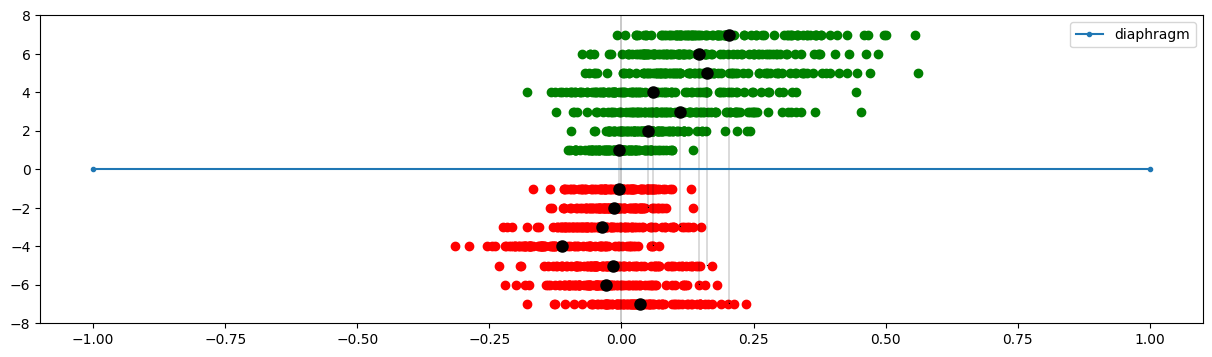

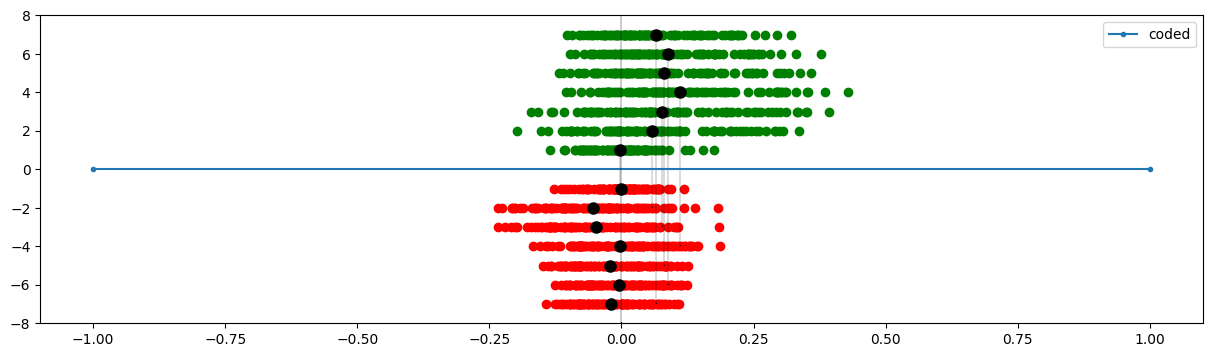

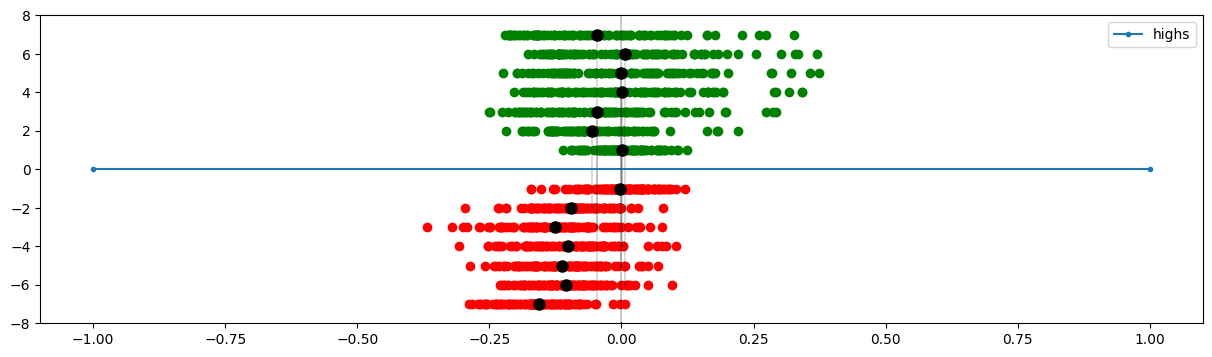

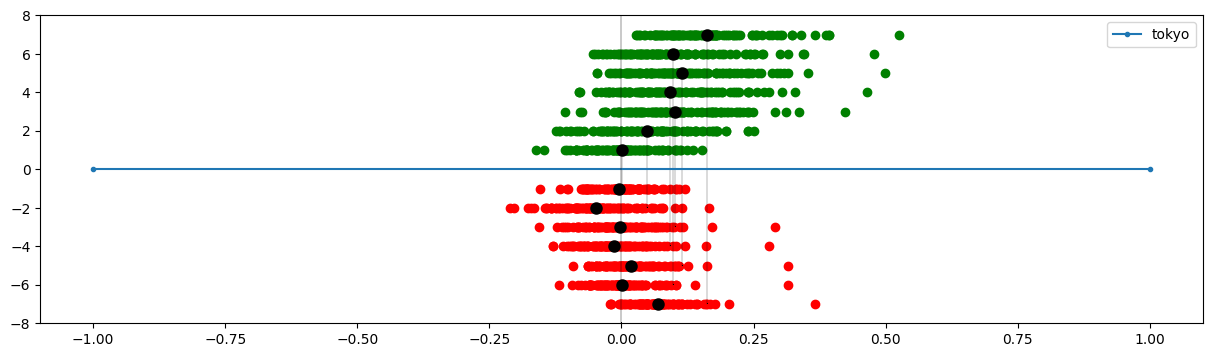

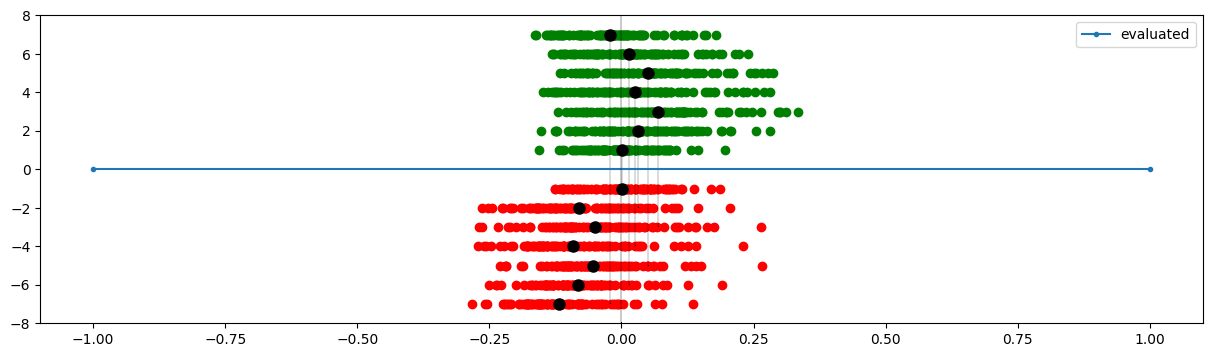

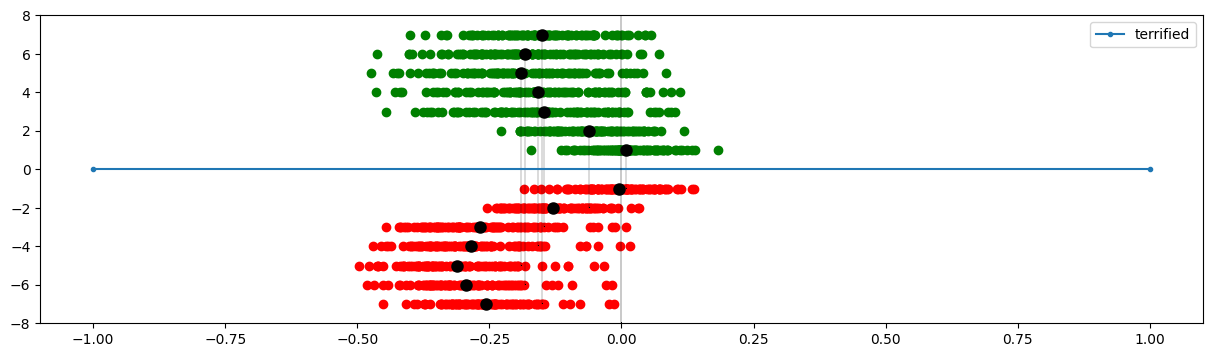

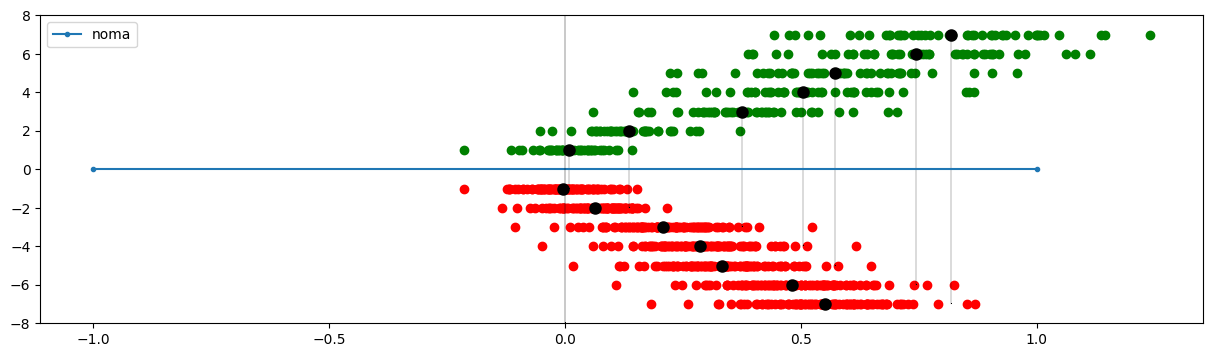

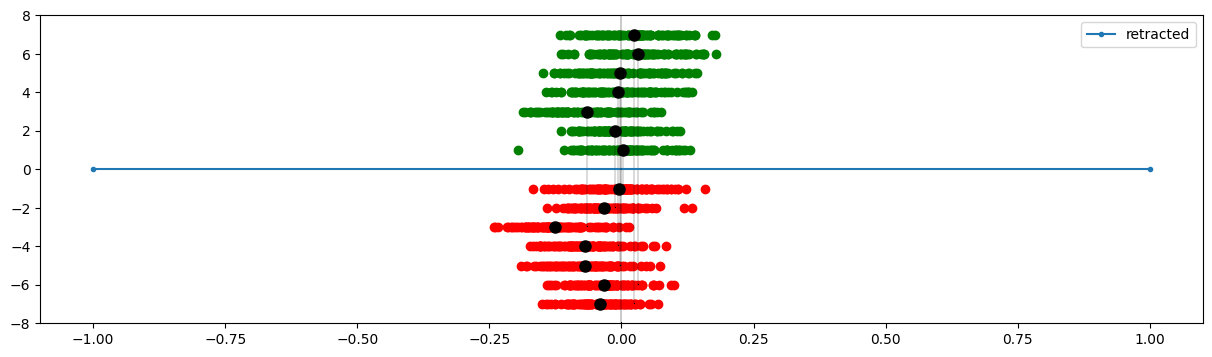

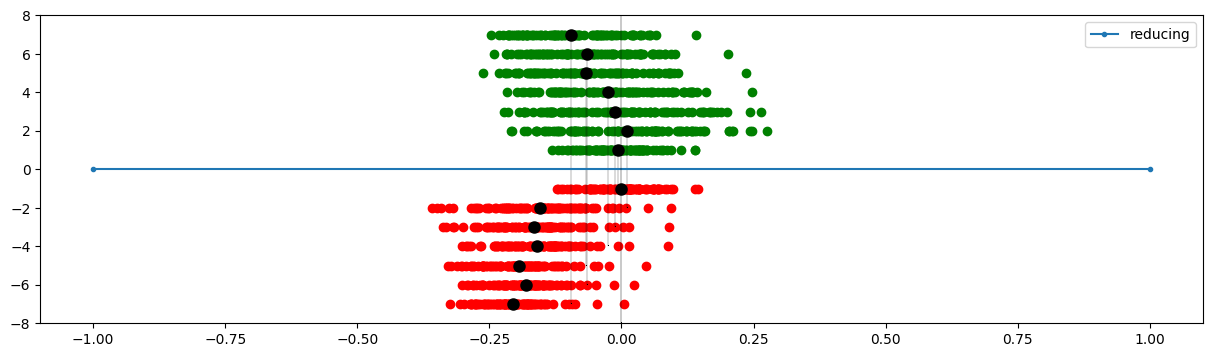

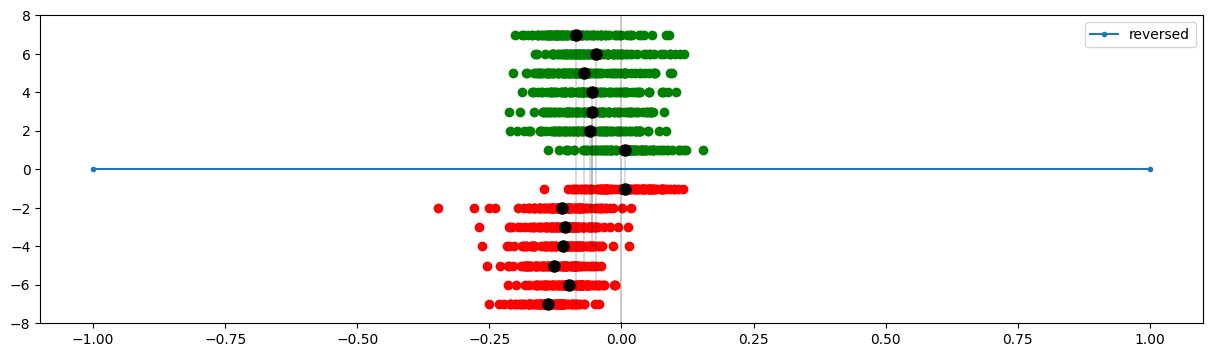

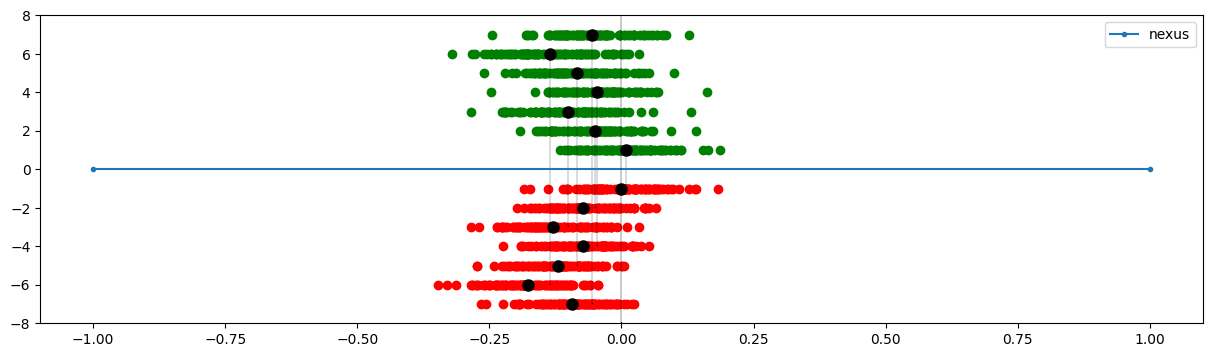

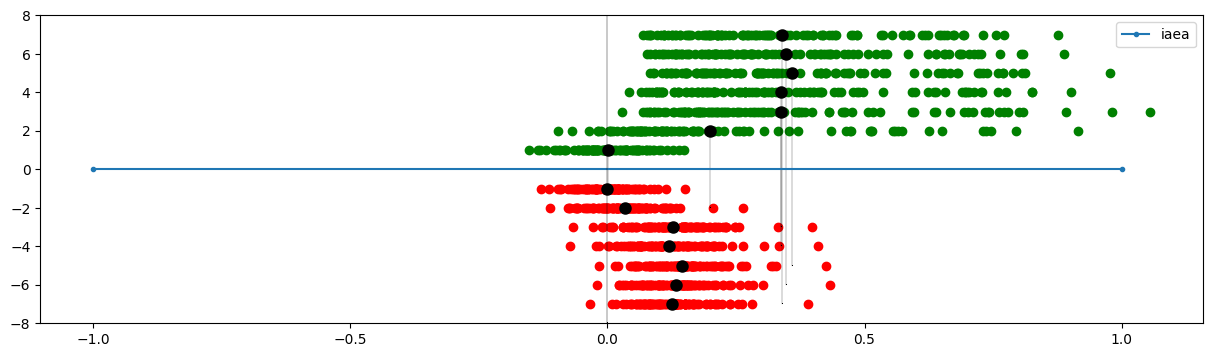

In [28]:
for trg in targets:
  contexts = test_dict[trg]["pos"]
  noises = test_dict[trg]["neg"]

  plt.figure(figsize=(15,4))

  for epoch in range(len(models2)):
    target_vectors = models2[epoch].embedding_input_dictionary()
    context_vectors = models2[epoch].embedding_output_dictionary()

    context_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in contexts]
    noise_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in noises]

    plt.scatter(context_projections, [epoch+1] * len(context_projections), color="green")
    plt.scatter([statistics.mean(context_projections)], [epoch+1], color="black", linewidths=3.0)
    x1, y1 = [statistics.mean(context_projections), statistics.mean(context_projections)], [-(epoch+1), (epoch+1)]
    plt.plot(x1, y1, marker = ',', color="black", linewidth=0.2)

    plt.scatter(noise_projections, [-(epoch+1)] * len(noise_projections), color="red")
    plt.scatter([statistics.mean(noise_projections)], [-(epoch+1)], color="black", linewidths=3.0)

  #magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
  magnitude = 1.0
  x1, y1 = [-magnitude, +magnitude], [0, 0]
  plt.plot(x1, y1, marker = '.', label=trg)

  x1, y1 = [0, 0], [-(epoch+2), (epoch+2)]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

  plt.legend()
  plt.ylim((-(epoch+2), (epoch+2)))
  plt.show()

## Clustering projections

In [29]:
cluster_dict = {model_idx: {i:0 for i in range(2,9)} for model_idx in range(len(models2))}
ideal_cluster_dict = {word:[0, 0, list()] for word in test_dict.keys()}

for model_idx in range(len(models2)):

  trg_emb = models2[model_idx].embedding_input_dictionary()
  ctx_emb = models2[model_idx].embedding_output_dictionary()
  counter = 0
  print()

  for word, samples in test_dict.items():

    contexts = samples["pos"]

    ideal_cluster_dict[word][1] = 0
    ideal_cluster_dict[word][0] = 0

    for k in range(2,9):

      score, cluster_indices = kmeans_cluster(k, [orthogonal_projection_position(word, ctx, trg_emb, ctx_emb) for ctx in contexts])
      #clusters = [[contexts[idx] for idx in cluster] for cluster in cluster_indices.values()]

      cluster_dict[model_idx][k] = cluster_dict[model_idx][k] + (score / len(test_dict.items()))

      if ideal_cluster_dict[word][1] < score:
        ideal_cluster_dict[word][1] = score
        ideal_cluster_dict[word][0] = k
    ideal_cluster_dict[word][2].append((ideal_cluster_dict[word][0], ideal_cluster_dict[word][1]))

    counter += 1
    print("\r[MODEL #%d] Progress: %d/%d" % (model_idx, counter, len(test_dict.items())), end='')

  print("\n", cluster_dict[model_idx])


[MODEL #0] Progress: 50/50
 {2: 0.56273207716401, 3: 0.548796103003911, 4: 0.5462564593172061, 5: 0.5549147140381727, 6: 0.5583220352658942, 7: 0.5573116454616036, 8: 0.5526803835607554}

[MODEL #1] Progress: 50/50
 {2: 0.5792733955517847, 3: 0.5615107254705058, 4: 0.5603256339977972, 5: 0.5514711001265306, 6: 0.5483618249562195, 7: 0.5505011186906128, 8: 0.554610600685431}

[MODEL #2] Progress: 50/50
 {2: 0.5879914230888915, 3: 0.5607528655532538, 4: 0.5562304451147114, 5: 0.5515708464220574, 6: 0.5536238647060813, 7: 0.5544333194655868, 8: 0.5618932004660183}

[MODEL #3] Progress: 50/50
 {2: 0.5880495850246287, 3: 0.5612512509981745, 4: 0.5552401745832087, 5: 0.5588890438960639, 6: 0.549745526271101, 7: 0.5582791115671611, 8: 0.5646491812691692}

[MODEL #4] Progress: 50/50
 {2: 0.5943322789978359, 3: 0.5553857899075253, 4: 0.5512456512098383, 5: 0.5492470211931836, 6: 0.5504013681728893, 7: 0.5525986979166674, 8: 0.5627414607258092}

[MODEL #5] Progress: 50/50
 {2: 0.593993045415904

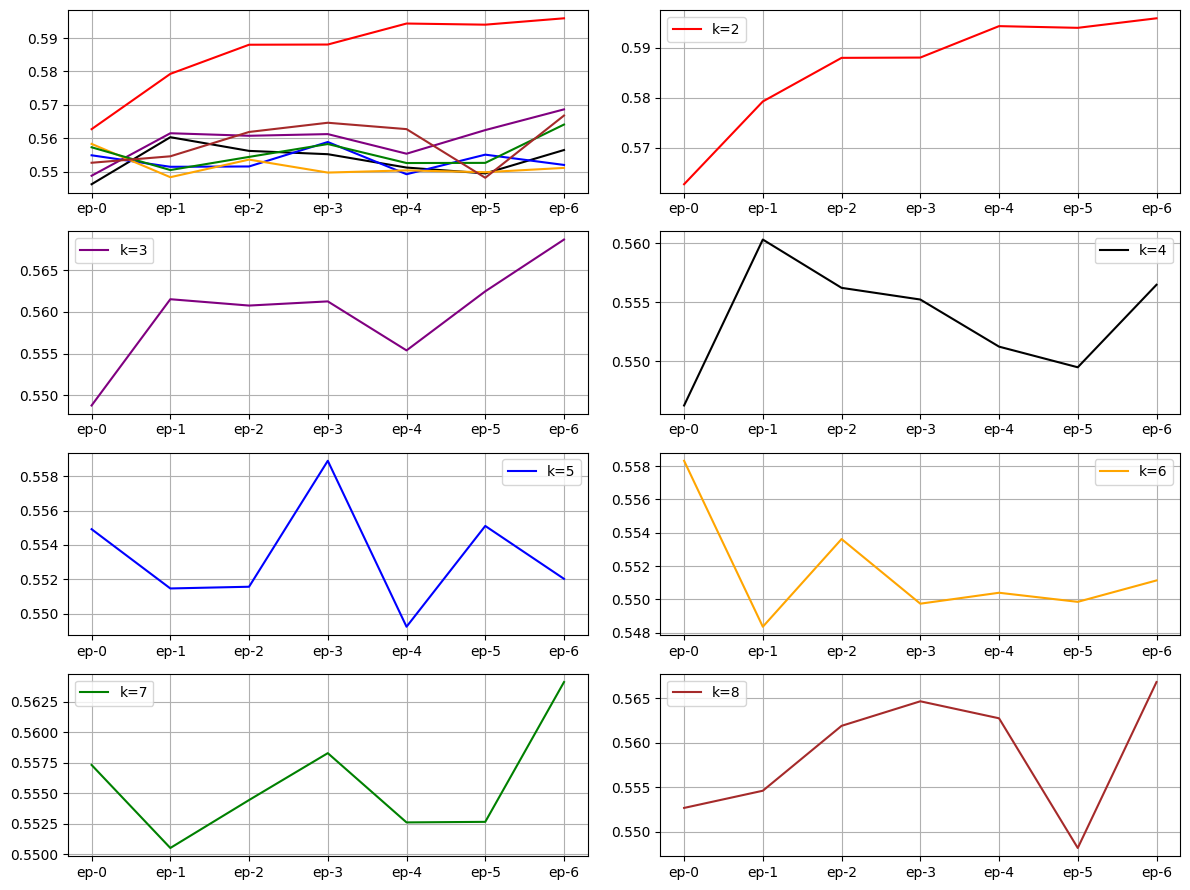

In [30]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 9))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")

ax2.grid(axis='both')
ax2.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax6.legend()

ax7.grid(axis='both')
ax7.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax7.legend()

ax8.grid(axis='both')
ax8.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")
ax8.legend()


fig.tight_layout()
fig.show()

In [31]:
cluster_table = PrettyTable()
cluster_table.field_names = ["Target", "Ideal Nr of Clusters per Epoch", "Score"]
for word in test_dict.keys():
  cluster_table.add_row([word, [x[0] for x in ideal_cluster_dict[word][2]], ["%.3f"%x[1] for x in ideal_cluster_dict[word][2]]])

print(cluster_table)

+--------------+--------------------------------+-----------------------------------------------------------------+
|    Target    | Ideal Nr of Clusters per Epoch |                              Score                              |
+--------------+--------------------------------+-----------------------------------------------------------------+
|   removes    |     [4, 8, 2, 8, 2, 2, 2]      | ['0.601', '0.572', '0.599', '0.580', '0.569', '0.589', '0.585'] |
|   lowland    |     [2, 2, 2, 2, 2, 7, 2]      | ['0.581', '0.600', '0.621', '0.611', '0.589', '0.615', '0.577'] |
|  accustomed  |     [2, 3, 8, 5, 8, 3, 2]      | ['0.557', '0.610', '0.580', '0.562', '0.604', '0.561', '0.574'] |
|   refuted    |     [2, 8, 6, 7, 3, 8, 4]      | ['0.607', '0.576', '0.591', '0.593', '0.567', '0.597', '0.564'] |
|   wetland    |     [8, 3, 4, 4, 8, 2, 4]      | ['0.581', '0.583', '0.640', '0.604', '0.568', '0.583', '0.592'] |
|    wrong     |     [7, 8, 2, 3, 3, 3, 7]      | ['0.621', '0.552', '0.

# v18

In [32]:
models3 = models[2]

## Stats

In [33]:
stats_table, stats_dict = get_stats(models3, test_dict)


[MODEL #0] Progress: 50/50
[MODEL #1] Progress: 50/50
[MODEL #2] Progress: 50/50
[MODEL #3] Progress: 50/50
[MODEL #4] Progress: 50/50
[MODEL #5] Progress: 50/50
[MODEL #6] Progress: 50/50

### Stats Dictionary
1. Average context (ctx repr.) projections on target (trg repr.)
2. Average noise (ctx repr.) projections on target (trg repr.)
3. Average ***variance*** of context (ctx repr.) projections on target (trg repr.)
4. Average projection **difference** of context (ctx repr.) and noise (ctx repr.) on target (trg repr.)
5. Average ***cos-similarity*** of context (trg repr.) and target (trg repr.)
6. Average target magnitude

In [34]:
print(stats_table)

+--------------+--------+--------+-------+-------+-------+--------+
|    Target    |   1    |   2    |   3   |   4   |   5   |   6    |
+--------------+--------+--------+-------+-------+-------+--------+
|   removes    | -0.019 | -0.068 | 0.003 | 0.049 | 0.078 | 19.333 |
|   lowland    | 0.084  | 0.002  | 0.004 | 0.083 | 0.166 | 17.514 |
|  accustomed  | -0.087 | -0.116 | 0.002 | 0.029 | 0.022 | 18.763 |
|   refuted    | 0.047  | 0.004  | 0.003 | 0.044 | 0.071 | 18.279 |
|   wetland    | 0.082  | -0.003 | 0.007 | 0.085 | 0.096 | 14.765 |
|    wrong     | -0.050 | -0.096 | 0.002 | 0.046 | 0.072 | 20.722 |
|  scattering  | -0.014 | -0.091 | 0.004 | 0.076 | 0.126 | 18.478 |
|  purifying   | 0.082  | 0.016  | 0.006 | 0.066 | 0.089 | 14.750 |
|  diaphragm   | 0.122  | 0.020  | 0.004 | 0.102 | 0.141 | 15.842 |
|    coded     | 0.069  | 0.015  | 0.003 | 0.054 | 0.103 | 19.331 |
|    highs     | 0.048  | -0.018 | 0.006 | 0.066 | 0.064 | 16.022 |
|    tokyo     | 0.116  | 0.063  | 0.002 | 0.053

In [35]:
for model_idx, values in stats_dict.items():
  print("EPOCH #%d [1: %.3f] [2: %.3f] [3: %.3f] [4: %.3f] [5: %.3f] [6: %.3f] " % (model_idx, values["avg_proj_1"], values["avg_noise_proj"], values["var_proj_1"], values["avg_proj_2"], values["avg_sim"], values["avg_mag"]))

EPOCH #0 [1: 0.001] [2: -0.000] [3: 0.003] [4: 0.001] [5: -0.002] [6: 10.011] 
EPOCH #1 [1: 0.017] [2: -0.028] [3: 0.003] [4: 0.046] [5: 0.045] [6: 11.517] 
EPOCH #2 [1: 0.033] [2: -0.028] [3: 0.004] [4: 0.061] [5: 0.075] [6: 12.920] 
EPOCH #3 [1: 0.043] [2: -0.021] [3: 0.004] [4: 0.064] [5: 0.085] [6: 14.225] 
EPOCH #4 [1: 0.045] [2: -0.021] [3: 0.004] [4: 0.066] [5: 0.089] [6: 15.445] 
EPOCH #5 [1: 0.051] [2: -0.014] [3: 0.004] [4: 0.065] [5: 0.090] [6: 16.576] 
EPOCH #6 [1: 0.056] [2: -0.008] [3: 0.004] [4: 0.064] [5: 0.091] [6: 17.643] 


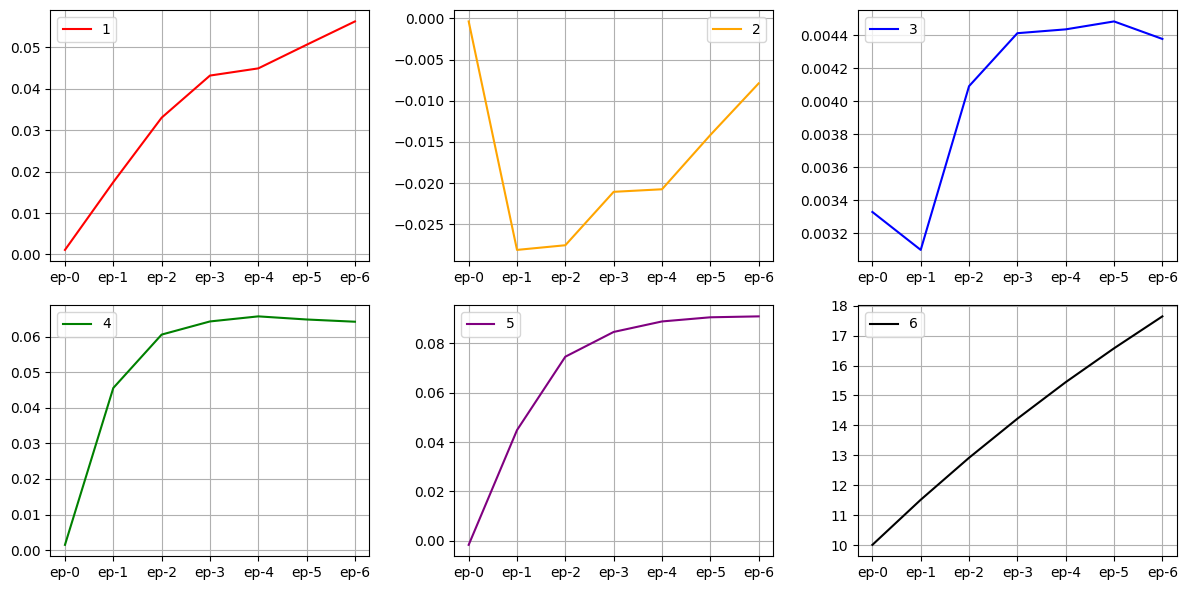

In [36]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_1"] for v in stats_dict.values()], label = "1", color="red")
ax1.legend()

ax2.grid(axis='both')
ax2.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_noise_proj"] for v in stats_dict.values()], label = "2", color="orange")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%x for x in stats_dict.keys()], [v["var_proj_1"] for v in stats_dict.values()], label = "3", color="blue")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_2"] for v in stats_dict.values()], label = "4", color="green")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_sim"] for v in stats_dict.values()], label = "5", color="purple")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_mag"] for v in stats_dict.values()], label = "6", color="black")
ax6.legend()

fig.tight_layout()
fig.show()

# Visualize distributions

In [37]:
test_indexes = range(0, 20)

targets = [list(test_dict.keys())[test_index] for test_index in test_indexes]

print("Visuaizing for: ", targets)

Visuaizing for:  ['removes', 'lowland', 'accustomed', 'refuted', 'wetland', 'wrong', 'scattering', 'purifying', 'diaphragm', 'coded', 'highs', 'tokyo', 'evaluated', 'terrified', 'noma', 'retracted', 'reducing', 'reversed', 'nexus', 'iaea']


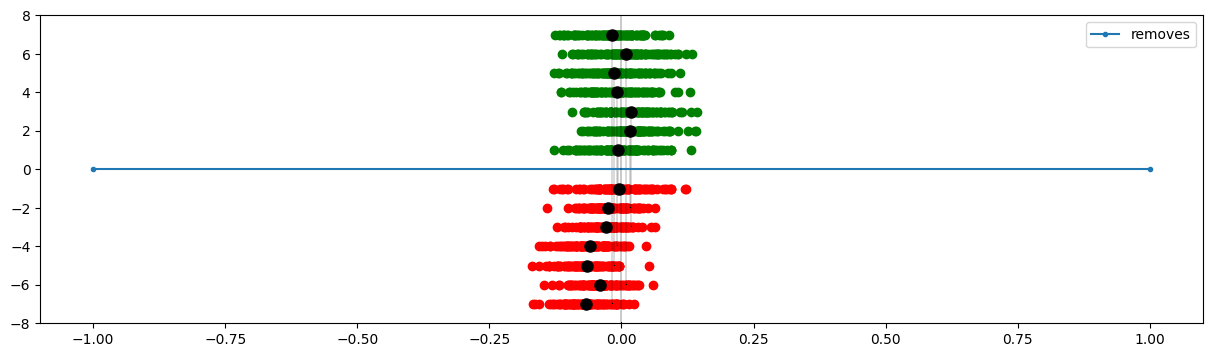

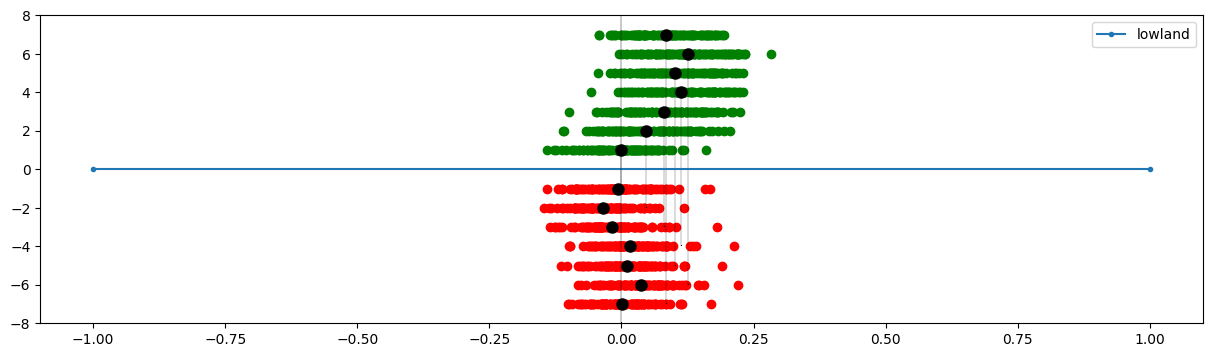

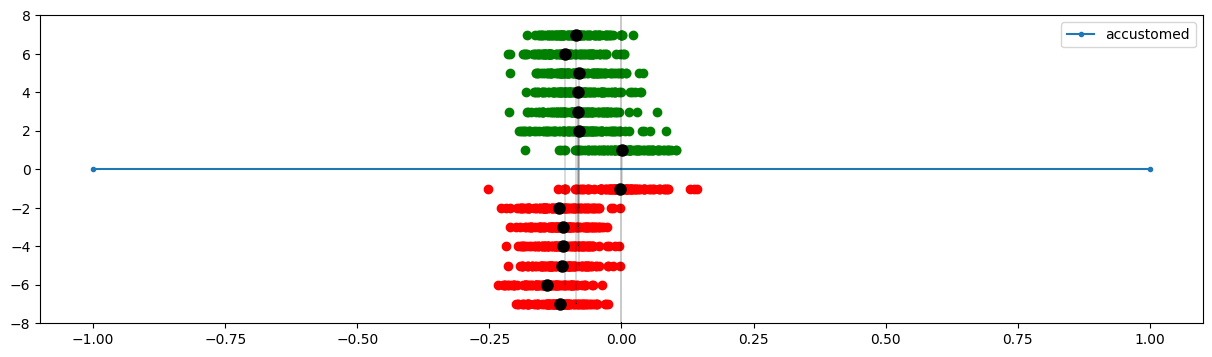

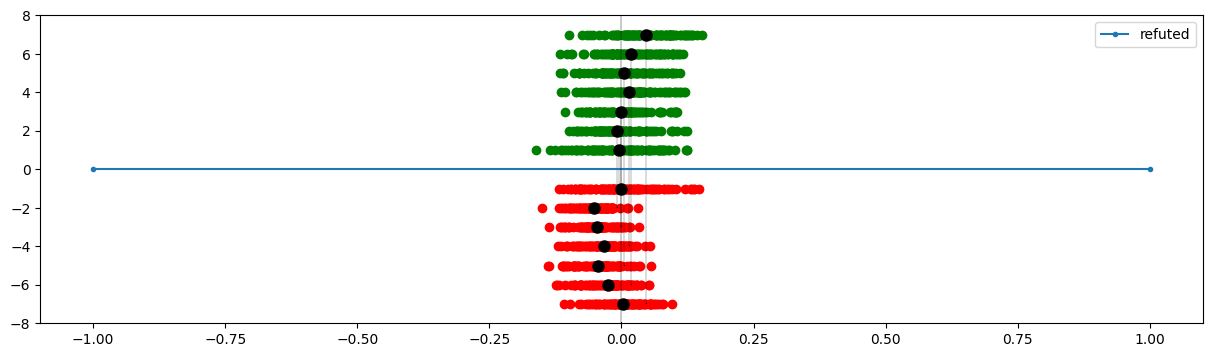

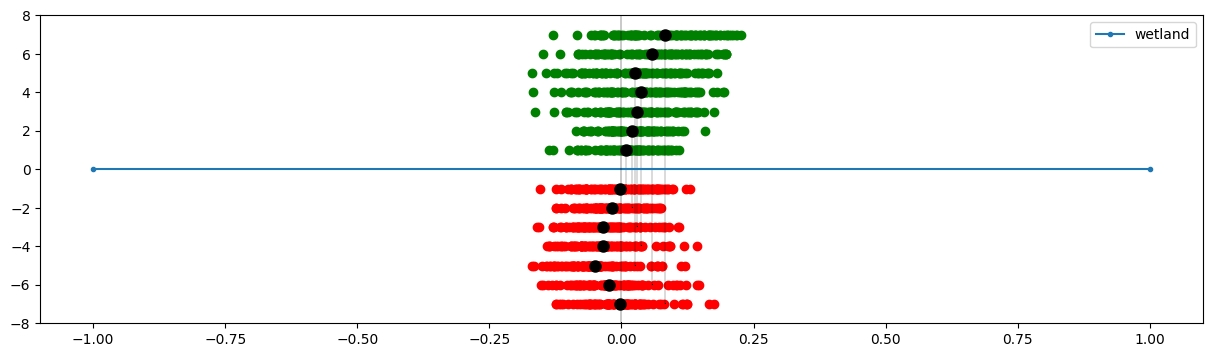

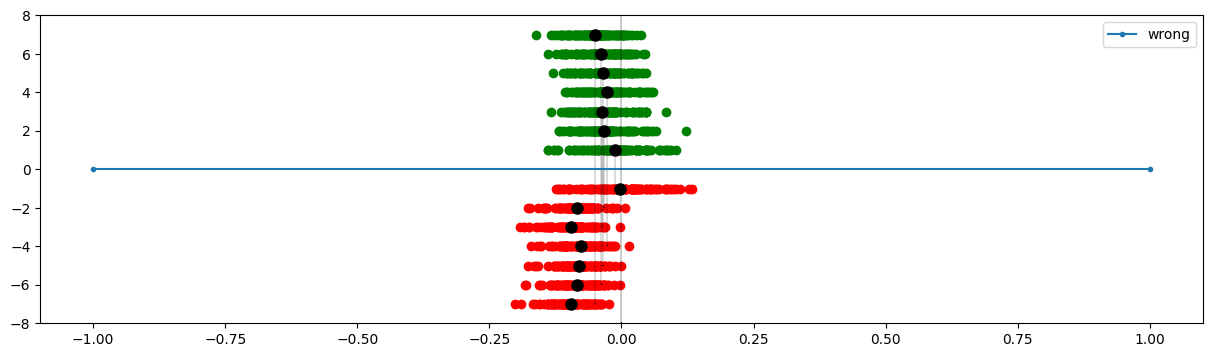

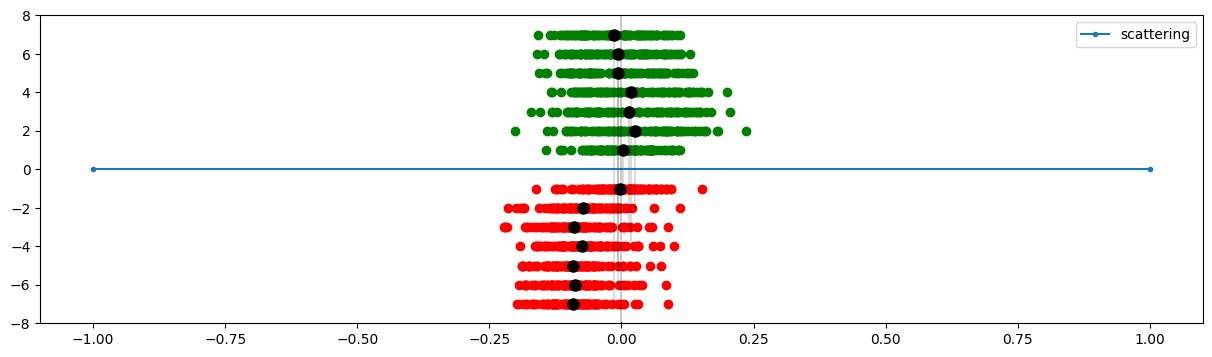

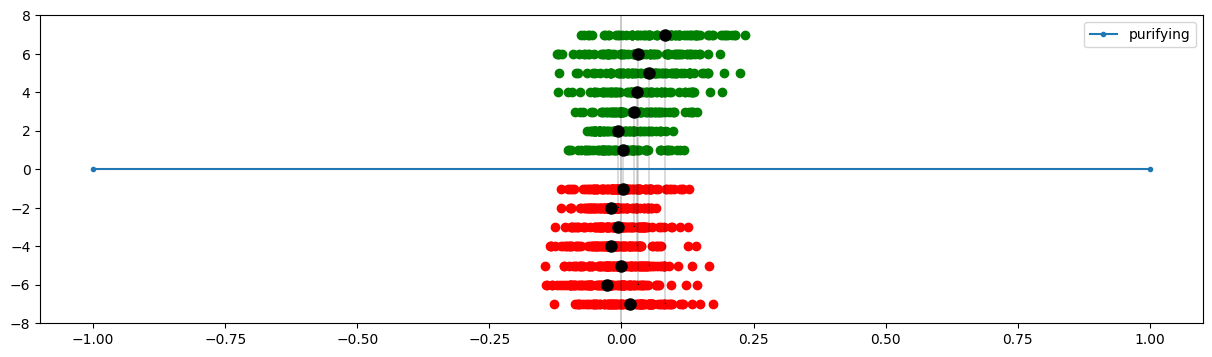

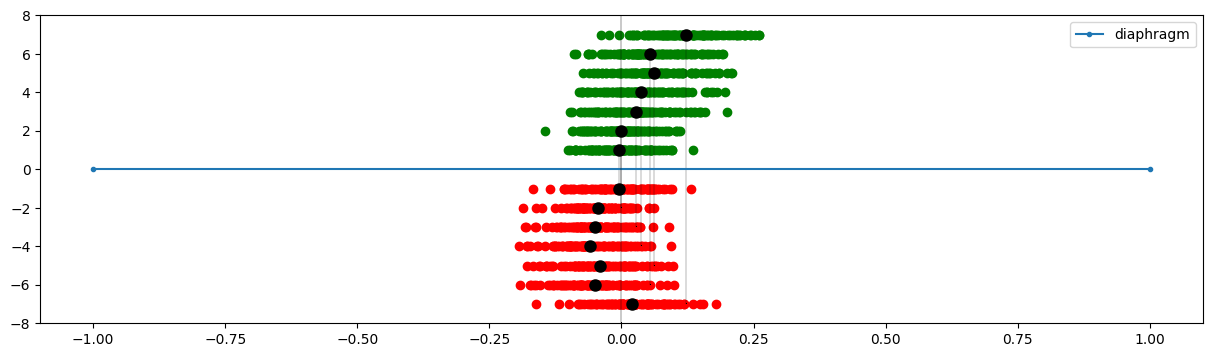

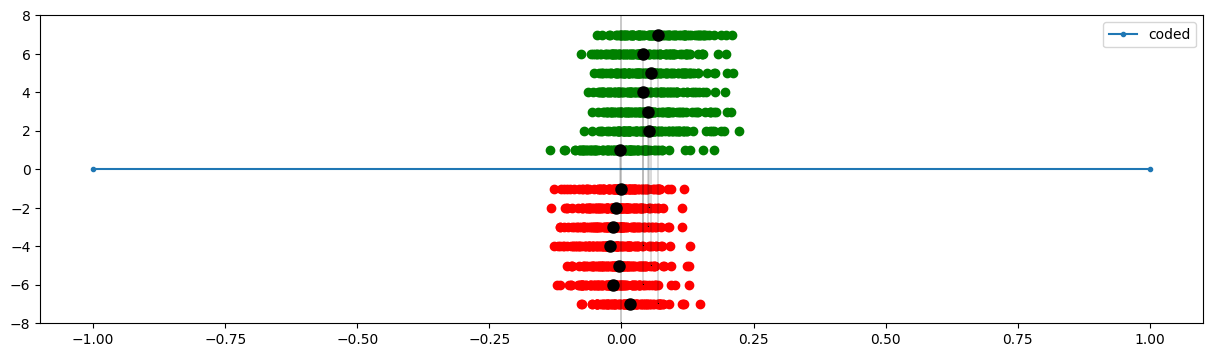

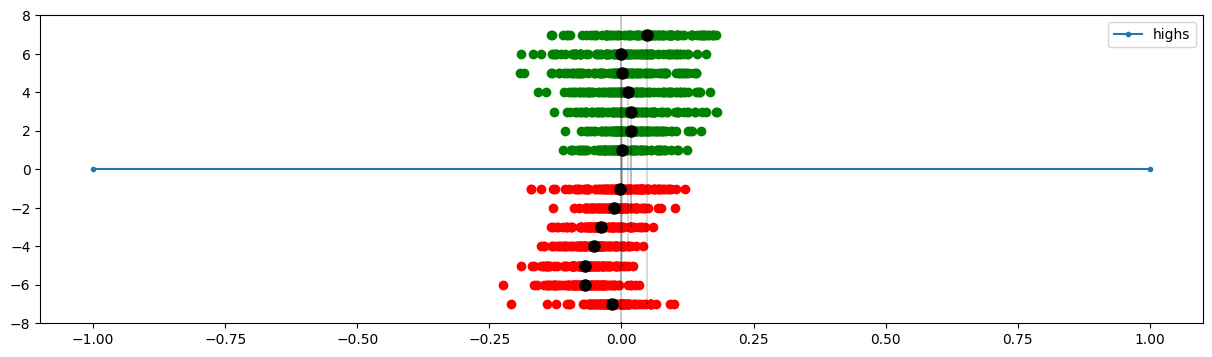

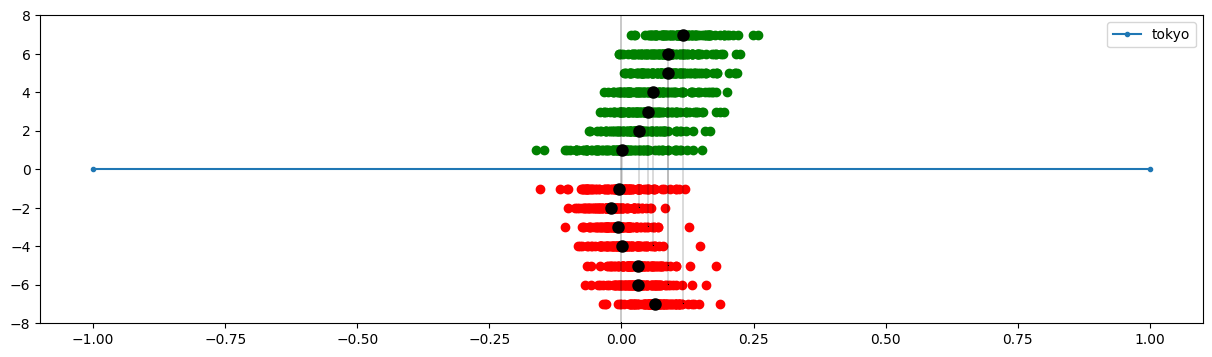

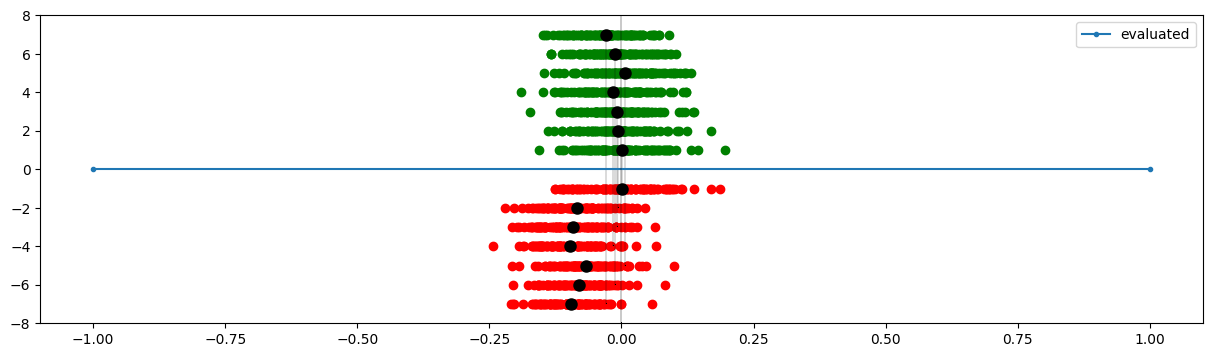

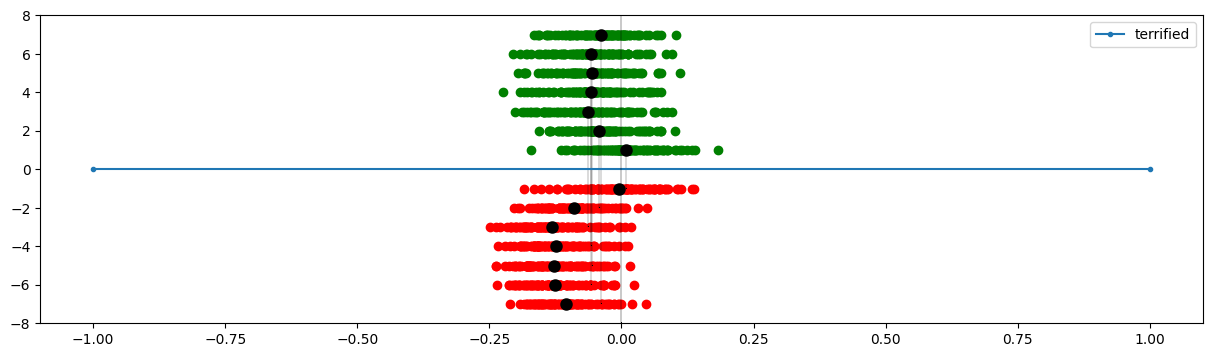

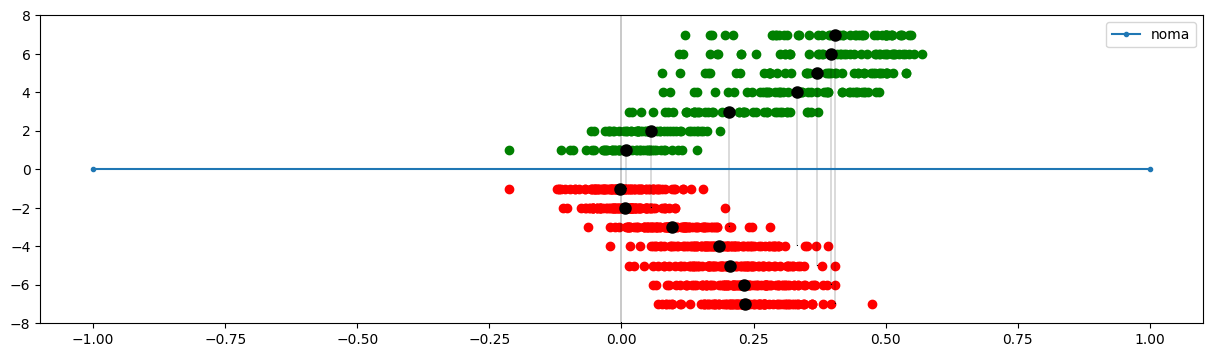

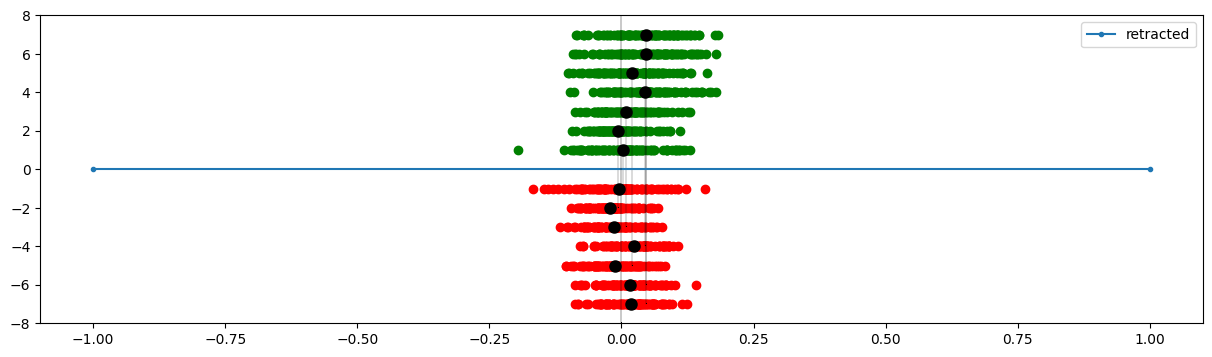

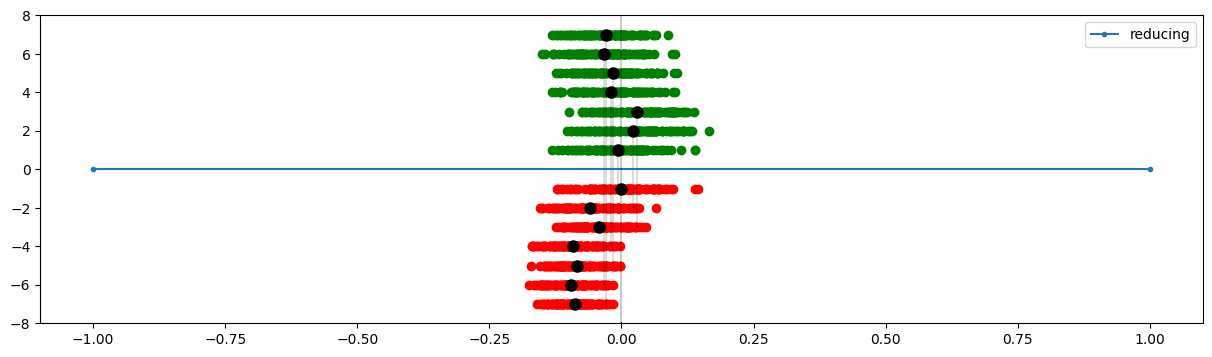

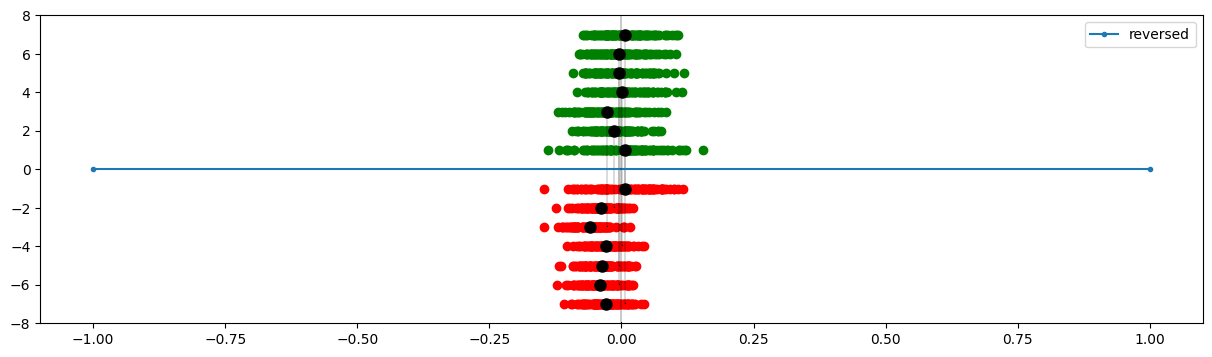

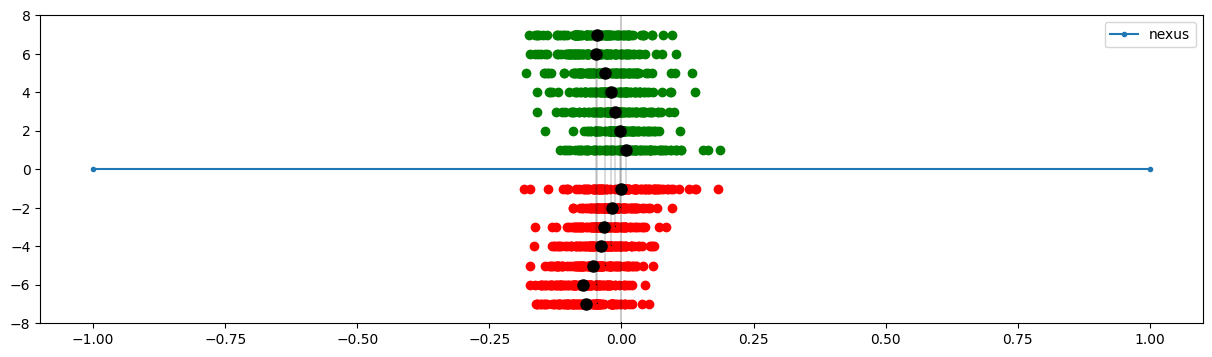

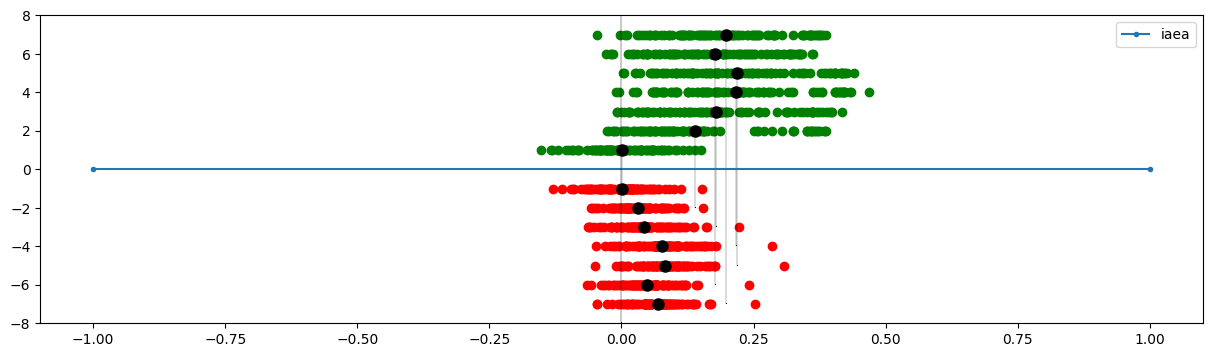

In [38]:
for trg in targets:
  contexts = test_dict[trg]["pos"]
  noises = test_dict[trg]["neg"]

  plt.figure(figsize=(15,4))

  for epoch in range(len(models3)):
    target_vectors = models3[epoch].embedding_input_dictionary()
    context_vectors = models3[epoch].embedding_output_dictionary()

    context_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in contexts]
    noise_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in noises]

    plt.scatter(context_projections, [epoch+1] * len(context_projections), color="green")
    plt.scatter([statistics.mean(context_projections)], [epoch+1], color="black", linewidths=3.0)
    x1, y1 = [statistics.mean(context_projections), statistics.mean(context_projections)], [-(epoch+1), (epoch+1)]
    plt.plot(x1, y1, marker = ',', color="black", linewidth=0.2)

    plt.scatter(noise_projections, [-(epoch+1)] * len(noise_projections), color="red")
    plt.scatter([statistics.mean(noise_projections)], [-(epoch+1)], color="black", linewidths=3.0)

  #magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
  magnitude = 1.0
  x1, y1 = [-magnitude, +magnitude], [0, 0]
  plt.plot(x1, y1, marker = '.', label=trg)

  x1, y1 = [0, 0], [-(epoch+2), (epoch+2)]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

  plt.legend()
  plt.ylim((-(epoch+2), (epoch+2)))
  plt.show()

## Clustering projections

In [39]:
cluster_dict = {model_idx: {i:0 for i in range(2,9)} for model_idx in range(len(models3))}
ideal_cluster_dict = {word:[0, 0, list()] for word in test_dict.keys()}

for model_idx in range(len(models3)):

  trg_emb = models3[model_idx].embedding_input_dictionary()
  ctx_emb = models3[model_idx].embedding_output_dictionary()
  counter = 0
  print()

  for word, samples in test_dict.items():

    contexts = samples["pos"]

    ideal_cluster_dict[word][1] = 0
    ideal_cluster_dict[word][0] = 0

    for k in range(2,9):

      score, cluster_indices = kmeans_cluster(k, [orthogonal_projection_position(word, ctx, trg_emb, ctx_emb) for ctx in contexts])
      #clusters = [[contexts[idx] for idx in cluster] for cluster in cluster_indices.values()]

      cluster_dict[model_idx][k] = cluster_dict[model_idx][k] + (score / len(test_dict.items()))

      if ideal_cluster_dict[word][1] < score:
        ideal_cluster_dict[word][1] = score
        ideal_cluster_dict[word][0] = k
    ideal_cluster_dict[word][2].append((ideal_cluster_dict[word][0], ideal_cluster_dict[word][1]))

    counter += 1
    print("\r[MODEL #%d] Progress: %d/%d" % (model_idx, counter, len(test_dict.items())), end='')

  print("\n", cluster_dict[model_idx])


[MODEL #0] Progress: 50/50
 {2: 0.56273207716401, 3: 0.548796103003911, 4: 0.5462564593172061, 5: 0.5549147140381727, 6: 0.5583220352658942, 7: 0.5573116454616036, 8: 0.5526803835607554}

[MODEL #1] Progress: 50/50
 {2: 0.5794320189961579, 3: 0.555690272023383, 4: 0.5560724792404707, 5: 0.5507886696724602, 6: 0.5543105267646773, 7: 0.5608260767676501, 8: 0.5596444198442605}

[MODEL #2] Progress: 50/50
 {2: 0.586566697286159, 3: 0.5625620127988771, 4: 0.5547223714488094, 5: 0.5547009638863348, 6: 0.5495664737511526, 7: 0.5546231189735288, 8: 0.5588335495955447}

[MODEL #3] Progress: 50/50
 {2: 0.588854285584126, 3: 0.5621688102408354, 4: 0.5649015807520743, 5: 0.5571831280735978, 6: 0.5568253660126284, 7: 0.5566169859097961, 8: 0.5598600269382432}

[MODEL #4] Progress: 50/50
 {2: 0.589843653073995, 3: 0.5613991114756043, 4: 0.5630213989814075, 5: 0.5594631302215339, 6: 0.551017010397524, 7: 0.5492442225698562, 8: 0.5585877722434376}

[MODEL #5] Progress: 50/50
 {2: 0.5868009957462914, 

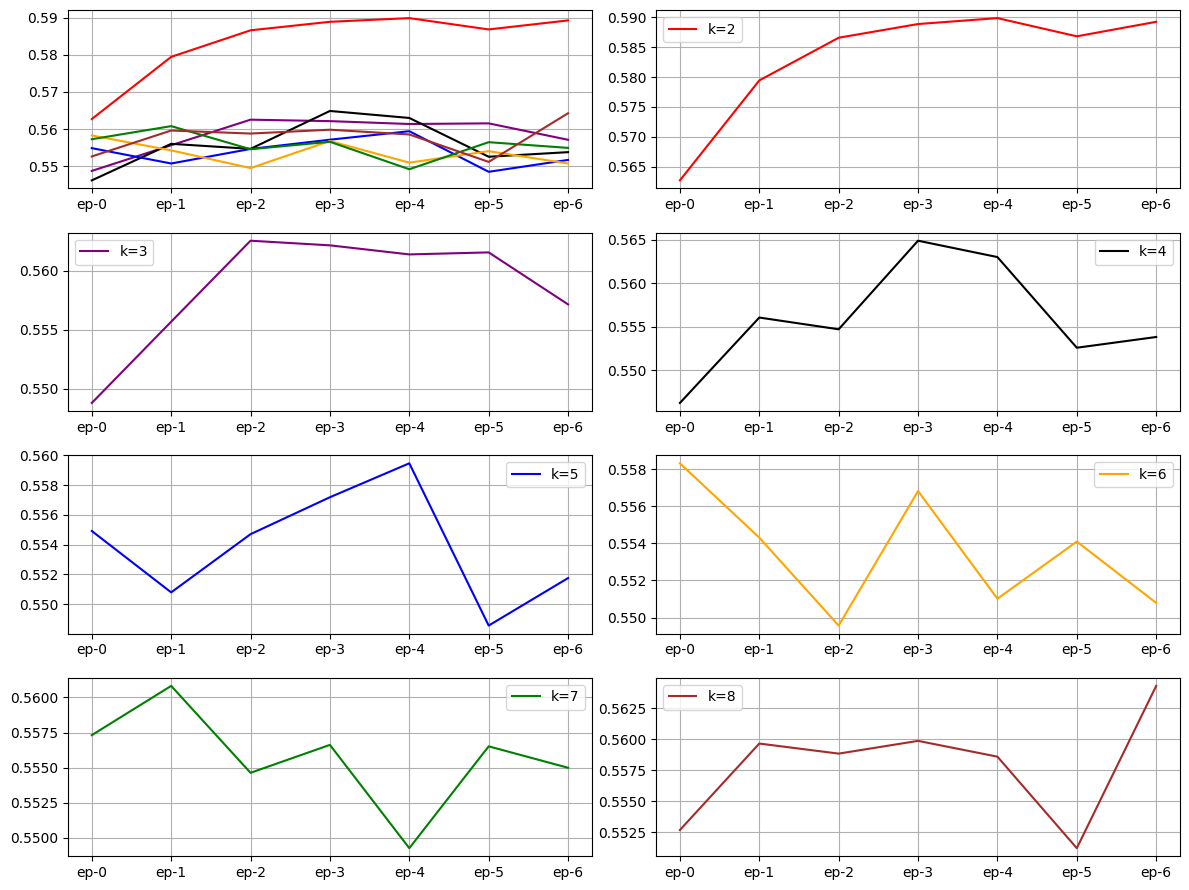

In [40]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 9))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")

ax2.grid(axis='both')
ax2.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax6.legend()

ax7.grid(axis='both')
ax7.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax7.legend()

ax8.grid(axis='both')
ax8.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")
ax8.legend()


fig.tight_layout()
fig.show()

In [41]:
cluster_table = PrettyTable()
cluster_table.field_names = ["Target", "Ideal Nr of Clusters per Epoch", "Score"]
for word in test_dict.keys():
  cluster_table.add_row([word, [x[0] for x in ideal_cluster_dict[word][2]], ["%.3f"%x[1] for x in ideal_cluster_dict[word][2]]])

print(cluster_table)

+--------------+--------------------------------+-----------------------------------------------------------------+
|    Target    | Ideal Nr of Clusters per Epoch |                              Score                              |
+--------------+--------------------------------+-----------------------------------------------------------------+
|   removes    |     [4, 7, 2, 2, 2, 4, 7]      | ['0.601', '0.601', '0.589', '0.577', '0.567', '0.593', '0.567'] |
|   lowland    |     [2, 2, 2, 2, 2, 2, 2]      | ['0.581', '0.615', '0.647', '0.603', '0.589', '0.581', '0.599'] |
|  accustomed  |     [2, 6, 7, 2, 2, 2, 8]      | ['0.557', '0.582', '0.589', '0.588', '0.616', '0.610', '0.585'] |
|   refuted    |     [2, 2, 3, 4, 5, 2, 2]      | ['0.607', '0.588', '0.615', '0.592', '0.578', '0.599', '0.600'] |
|   wetland    |     [8, 4, 4, 2, 5, 2, 2]      | ['0.581', '0.613', '0.592', '0.592', '0.593', '0.618', '0.644'] |
|    wrong     |     [7, 7, 4, 3, 5, 6, 3]      | ['0.621', '0.591', '0.

# v26

In [42]:
models4 = models[3]

## Stats

In [43]:
stats_table, stats_dict = get_stats(models4, test_dict)


[MODEL #0] Progress: 50/50
[MODEL #1] Progress: 50/50
[MODEL #2] Progress: 50/50
[MODEL #3] Progress: 50/50
[MODEL #4] Progress: 50/50
[MODEL #5] Progress: 50/50
[MODEL #6] Progress: 50/50

### Stats Dictionary
1. Average context (ctx repr.) projections on target (trg repr.)
2. Average noise (ctx repr.) projections on target (trg repr.)
3. Average ***variance*** of context (ctx repr.) projections on target (trg repr.)
4. Average projection **difference** of context (ctx repr.) and noise (ctx repr.) on target (trg repr.)
5. Average ***cos-similarity*** of context (trg repr.) and target (trg repr.)
6. Average target magnitude

In [44]:
print(stats_table)

+--------------+--------+--------+-------+-------+-------+--------+
|    Target    |   1    |   2    |   3   |   4   |   5   |   6    |
+--------------+--------+--------+-------+-------+-------+--------+
|   removes    | -0.012 | -0.071 | 0.004 | 0.059 | 0.079 | 19.045 |
|   lowland    | 0.175  | 0.068  | 0.007 | 0.107 | 0.181 | 18.538 |
|  accustomed  | -0.103 | -0.135 | 0.002 | 0.032 | 0.040 | 19.305 |
|   refuted    | 0.021  | -0.025 | 0.005 | 0.046 | 0.061 | 18.073 |
|   wetland    | 0.110  | 0.005  | 0.009 | 0.105 | 0.122 | 15.312 |
|    wrong     | -0.087 | -0.146 | 0.003 | 0.059 | 0.079 | 20.717 |
|  scattering  | 0.036  | -0.055 | 0.008 | 0.091 | 0.146 | 18.946 |
|  purifying   | 0.091  | 0.010  | 0.007 | 0.081 | 0.081 | 14.562 |
|  diaphragm   | 0.116  | -0.017 | 0.009 | 0.133 | 0.173 | 16.075 |
|    coded     | 0.086  | 0.017  | 0.006 | 0.070 | 0.132 | 18.740 |
|    highs     | 0.109  | 0.045  | 0.009 | 0.064 | 0.073 | 16.519 |
|    tokyo     | 0.145  | 0.064  | 0.006 | 0.081

In [45]:
for model_idx, values in stats_dict.items():
  print("EPOCH #%d [1: %.3f] [2: %.3f] [3: %.3f] [4: %.3f] [5: %.3f] [6: %.3f] " % (model_idx, values["avg_proj_1"], values["avg_noise_proj"], values["var_proj_1"], values["avg_proj_2"], values["avg_sim"], values["avg_mag"]))

EPOCH #0 [1: 0.001] [2: -0.000] [3: 0.003] [4: 0.001] [5: -0.002] [6: 10.011] 
EPOCH #1 [1: 0.022] [2: -0.030] [3: 0.004] [4: 0.053] [5: 0.052] [6: 11.559] 
EPOCH #2 [1: 0.036] [2: -0.038] [3: 0.006] [4: 0.074] [5: 0.085] [6: 12.936] 
EPOCH #3 [1: 0.052] [2: -0.026] [3: 0.007] [4: 0.077] [5: 0.096] [6: 14.228] 
EPOCH #4 [1: 0.063] [2: -0.016] [3: 0.007] [4: 0.079] [5: 0.100] [6: 15.431] 
EPOCH #5 [1: 0.063] [2: -0.016] [3: 0.007] [4: 0.079] [5: 0.101] [6: 16.607] 
EPOCH #6 [1: 0.064] [2: -0.015] [3: 0.007] [4: 0.078] [5: 0.102] [6: 17.687] 


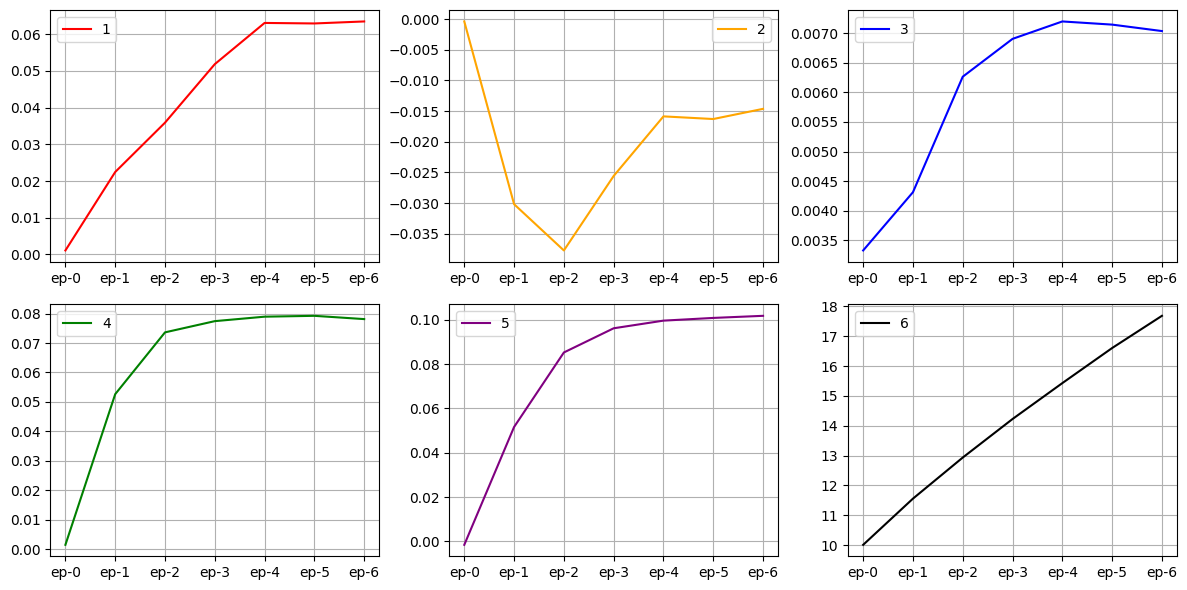

In [46]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_1"] for v in stats_dict.values()], label = "1", color="red")
ax1.legend()

ax2.grid(axis='both')
ax2.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_noise_proj"] for v in stats_dict.values()], label = "2", color="orange")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%x for x in stats_dict.keys()], [v["var_proj_1"] for v in stats_dict.values()], label = "3", color="blue")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_2"] for v in stats_dict.values()], label = "4", color="green")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_sim"] for v in stats_dict.values()], label = "5", color="purple")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_mag"] for v in stats_dict.values()], label = "6", color="black")
ax6.legend()

fig.tight_layout()
fig.show()

# Visualize distributions

In [47]:
test_indexes = range(0, 20)

targets = [list(test_dict.keys())[test_index] for test_index in test_indexes]

print("Visuaizing for: ", targets)

Visuaizing for:  ['removes', 'lowland', 'accustomed', 'refuted', 'wetland', 'wrong', 'scattering', 'purifying', 'diaphragm', 'coded', 'highs', 'tokyo', 'evaluated', 'terrified', 'noma', 'retracted', 'reducing', 'reversed', 'nexus', 'iaea']


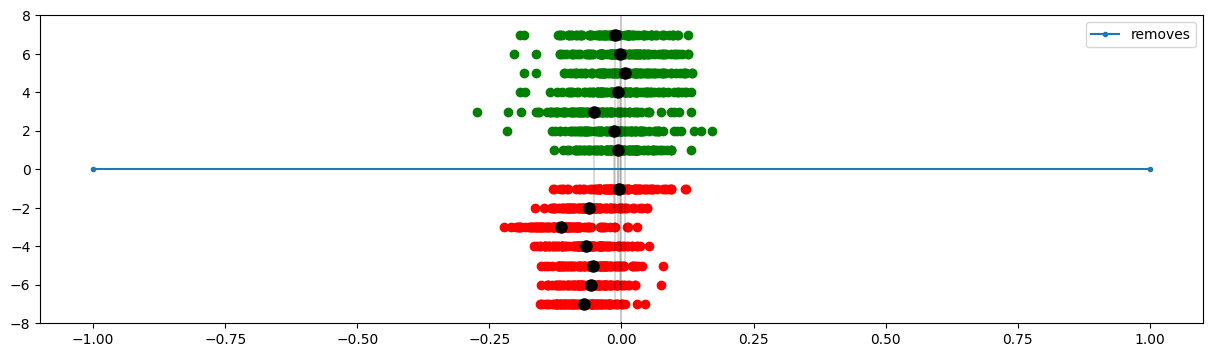

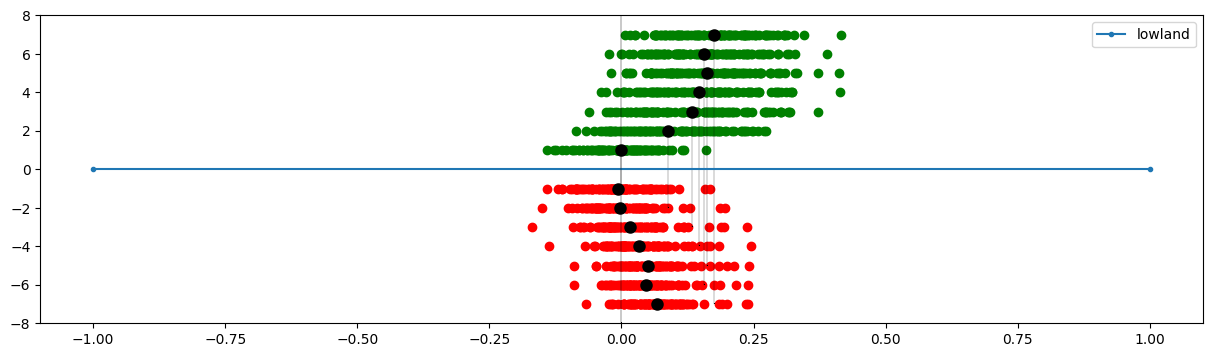

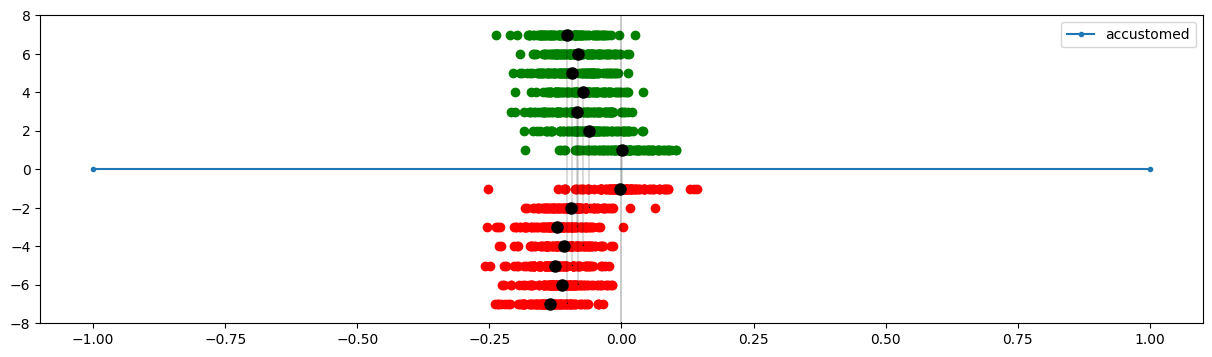

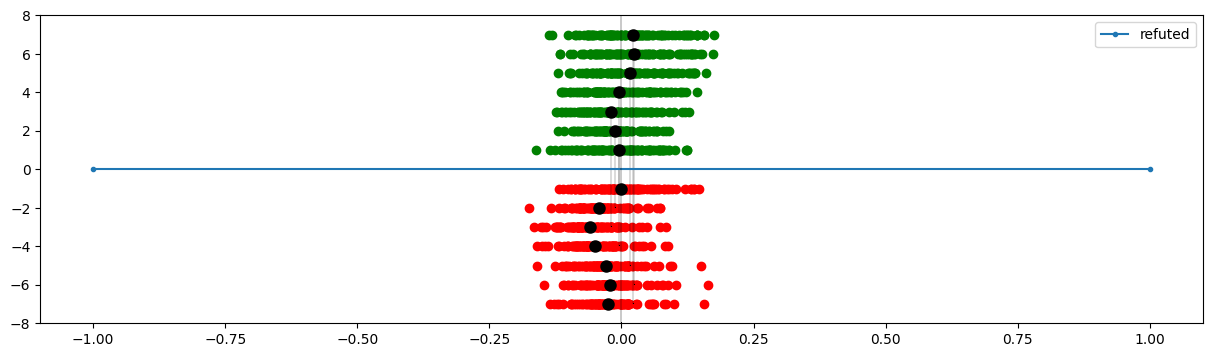

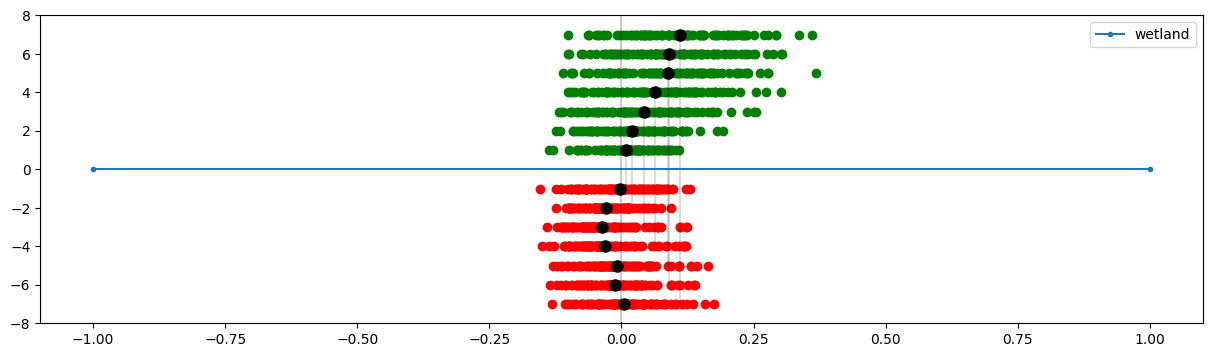

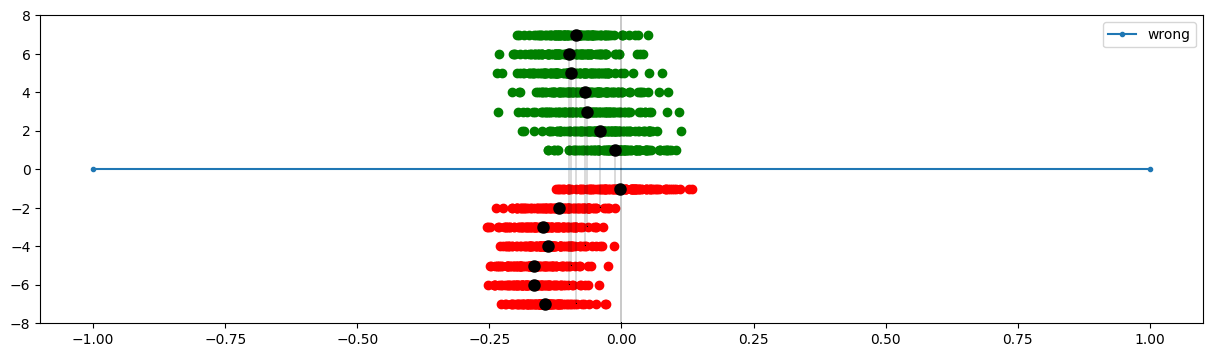

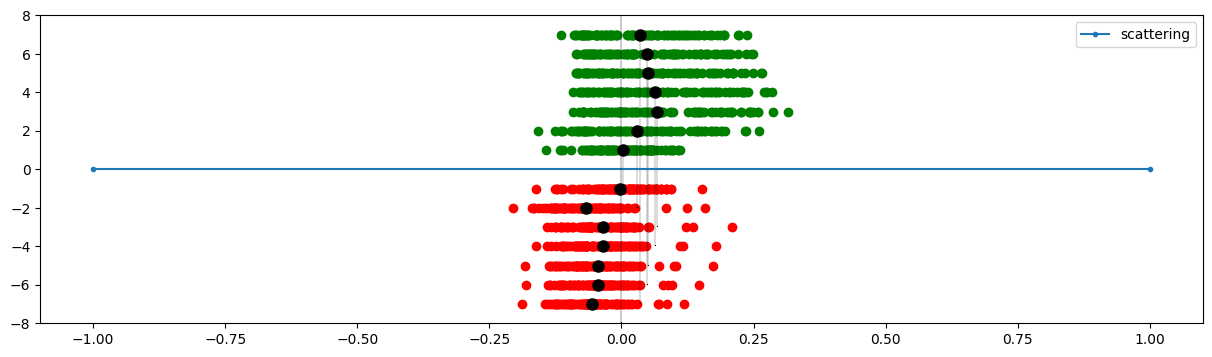

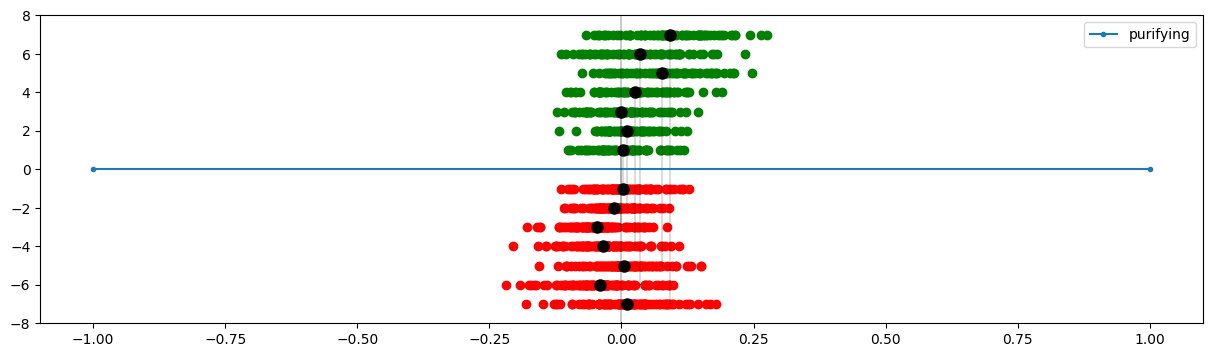

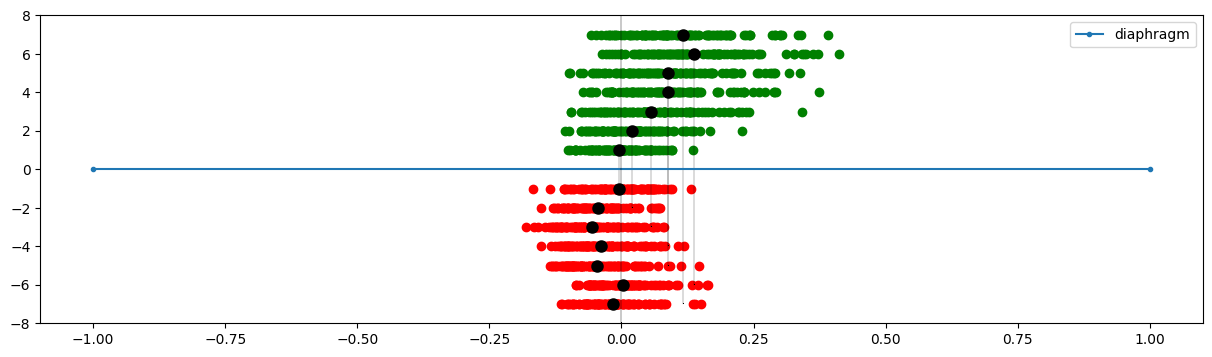

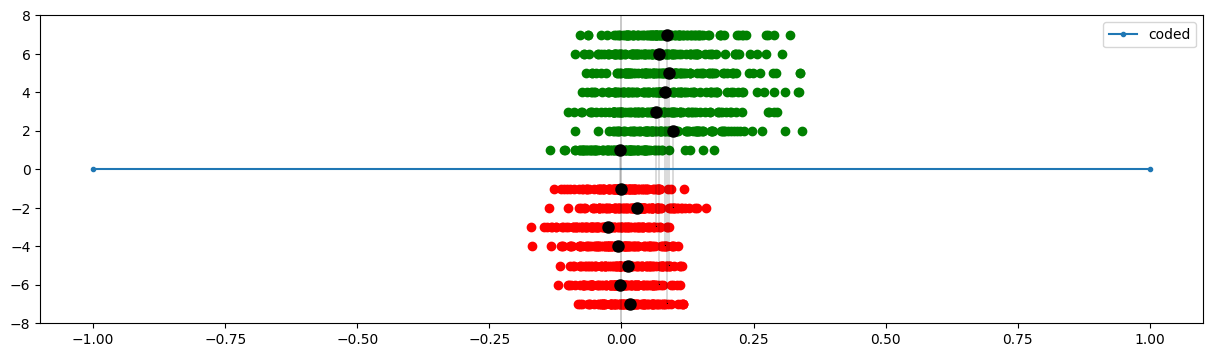

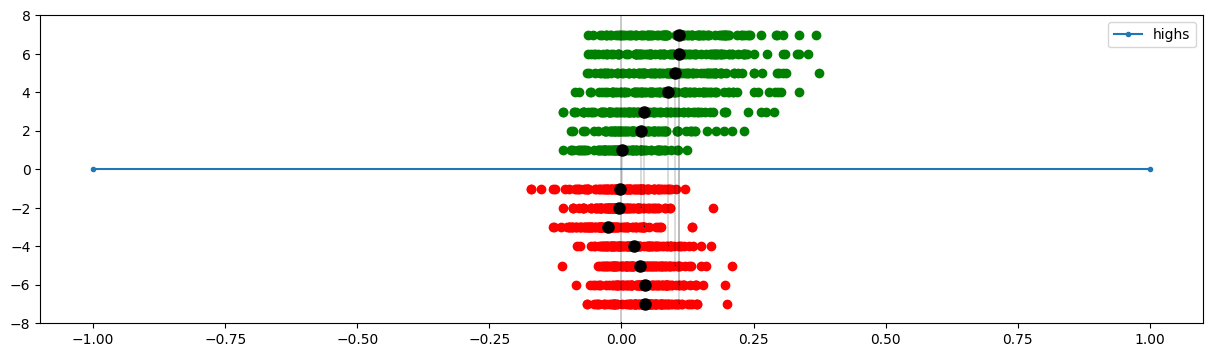

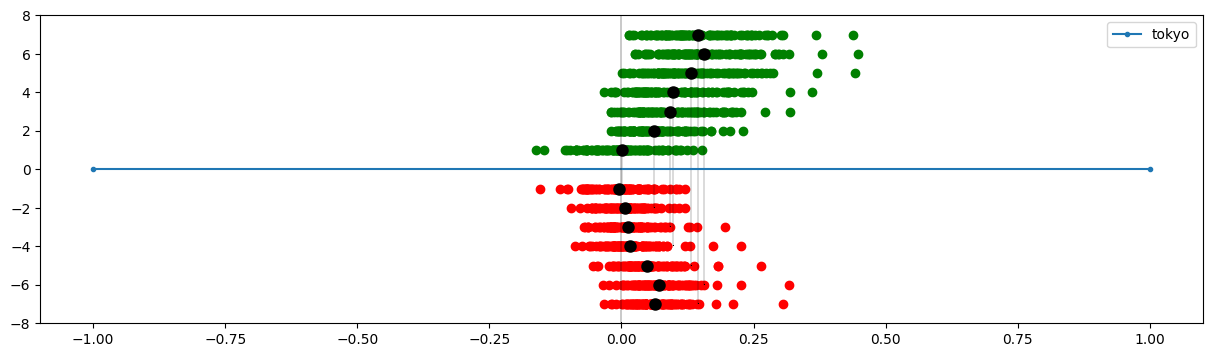

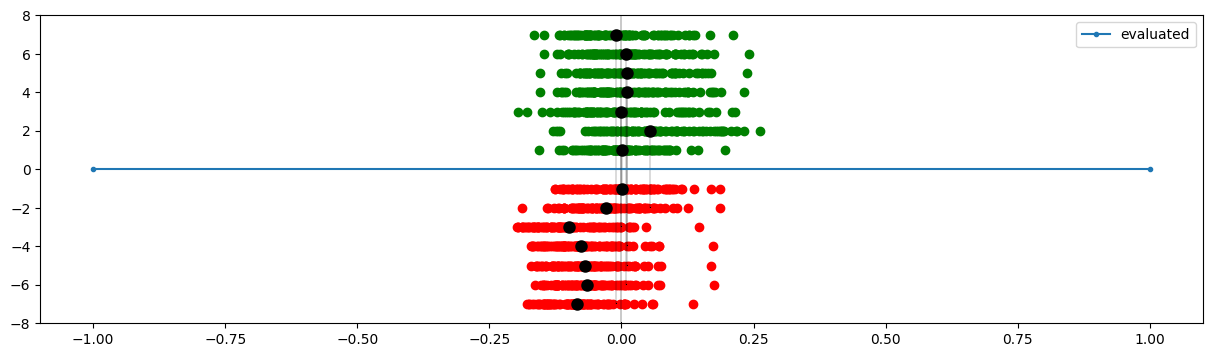

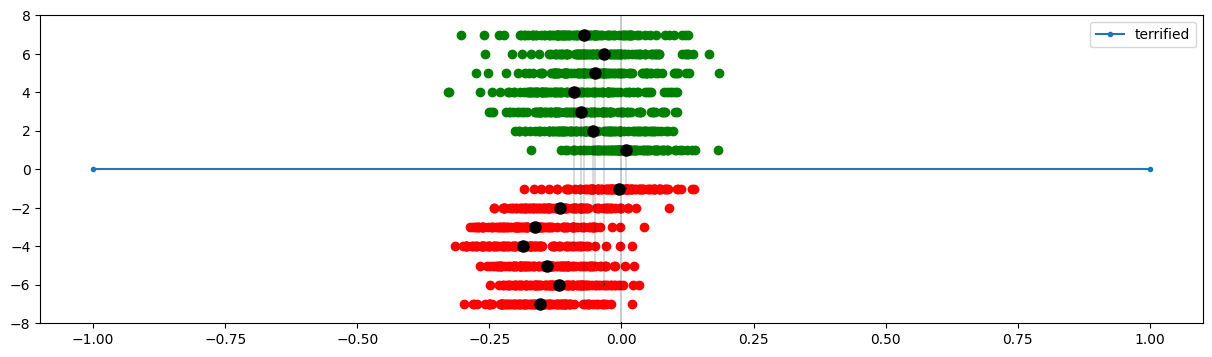

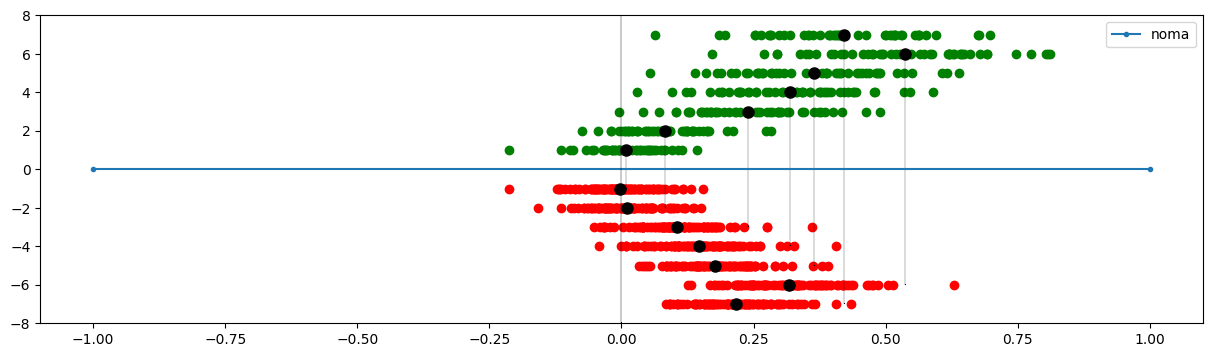

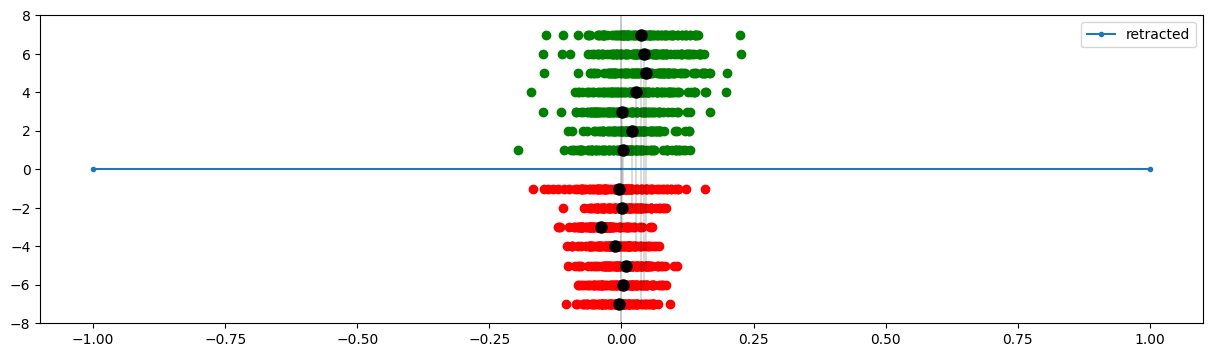

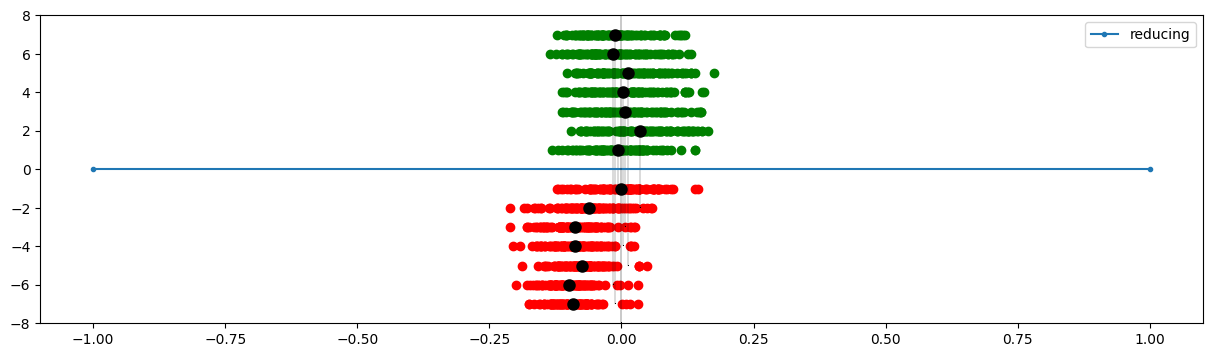

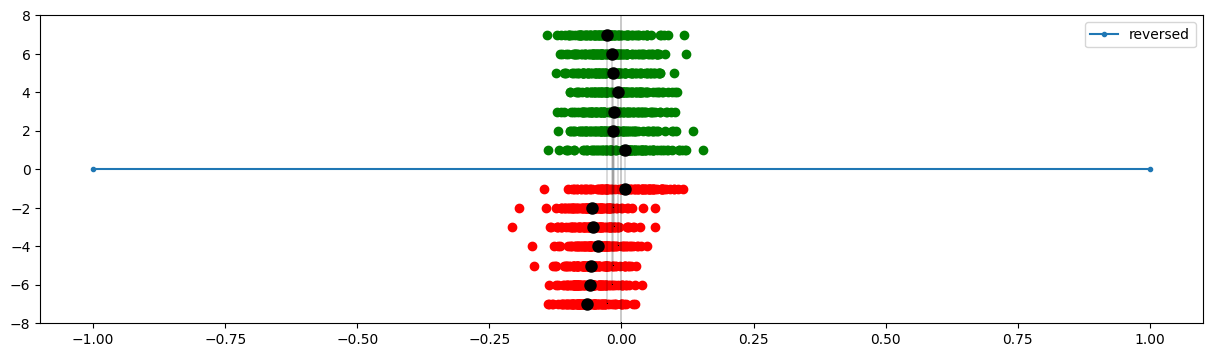

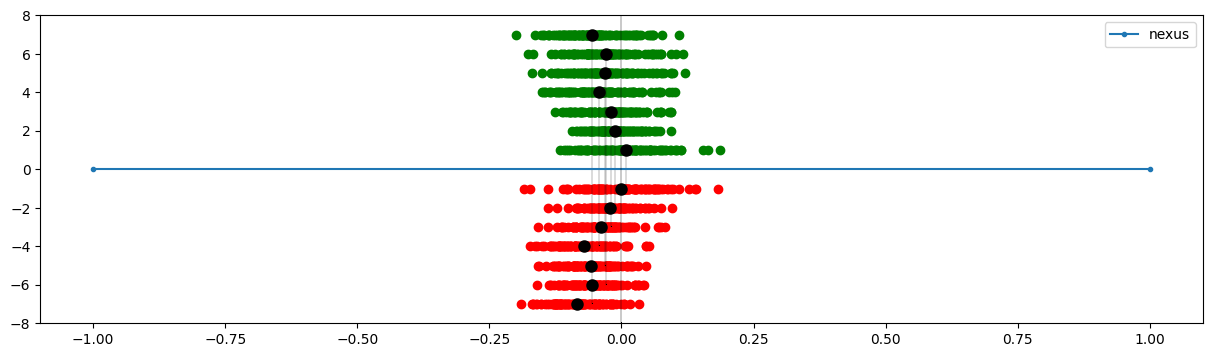

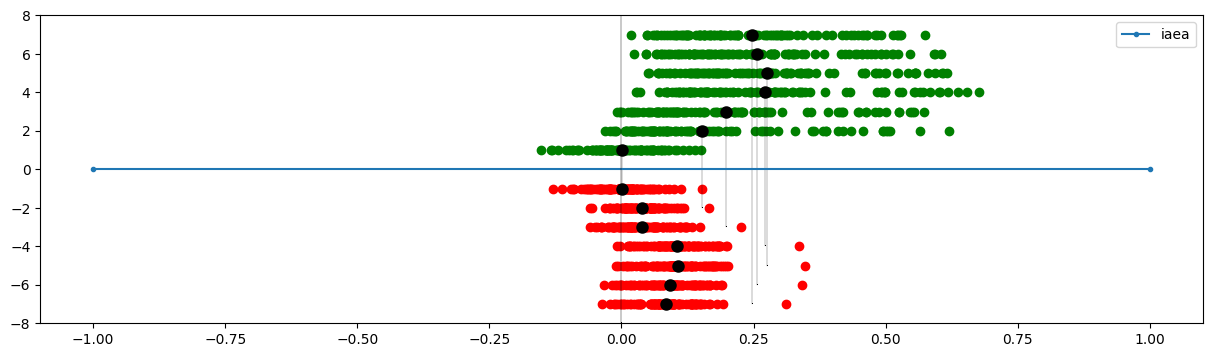

In [48]:
for trg in targets:
  contexts = test_dict[trg]["pos"]
  noises = test_dict[trg]["neg"]

  plt.figure(figsize=(15,4))

  for epoch in range(len(models4)):
    target_vectors = models4[epoch].embedding_input_dictionary()
    context_vectors = models4[epoch].embedding_output_dictionary()

    context_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in contexts]
    noise_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in noises]

    plt.scatter(context_projections, [epoch+1] * len(context_projections), color="green")
    plt.scatter([statistics.mean(context_projections)], [epoch+1], color="black", linewidths=3.0)
    x1, y1 = [statistics.mean(context_projections), statistics.mean(context_projections)], [-(epoch+1), (epoch+1)]
    plt.plot(x1, y1, marker = ',', color="black", linewidth=0.2)

    plt.scatter(noise_projections, [-(epoch+1)] * len(noise_projections), color="red")
    plt.scatter([statistics.mean(noise_projections)], [-(epoch+1)], color="black", linewidths=3.0)

  #magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
  magnitude = 1.0
  x1, y1 = [-magnitude, +magnitude], [0, 0]
  plt.plot(x1, y1, marker = '.', label=trg)

  x1, y1 = [0, 0], [-(epoch+2), (epoch+2)]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

  plt.legend()
  plt.ylim((-(epoch+2), (epoch+2)))
  plt.show()

## Clustering projections

In [49]:
cluster_dict = {model_idx: {i:0 for i in range(2,9)} for model_idx in range(len(models4))}
ideal_cluster_dict = {word:[0, 0, list()] for word in test_dict.keys()}

for model_idx in range(len(models4)):

  trg_emb = models4[model_idx].embedding_input_dictionary()
  ctx_emb = models4[model_idx].embedding_output_dictionary()
  counter = 0
  print()

  for word, samples in test_dict.items():

    contexts = samples["pos"]

    ideal_cluster_dict[word][1] = 0
    ideal_cluster_dict[word][0] = 0

    for k in range(2,9):

      score, cluster_indices = kmeans_cluster(k, [orthogonal_projection_position(word, ctx, trg_emb, ctx_emb) for ctx in contexts])
      #clusters = [[contexts[idx] for idx in cluster] for cluster in cluster_indices.values()]

      cluster_dict[model_idx][k] = cluster_dict[model_idx][k] + (score / len(test_dict.items()))

      if ideal_cluster_dict[word][1] < score:
        ideal_cluster_dict[word][1] = score
        ideal_cluster_dict[word][0] = k
    ideal_cluster_dict[word][2].append((ideal_cluster_dict[word][0], ideal_cluster_dict[word][1]))

    counter += 1
    print("\r[MODEL #%d] Progress: %d/%d" % (model_idx, counter, len(test_dict.items())), end='')

  print("\n", cluster_dict[model_idx])


[MODEL #0] Progress: 50/50
 {2: 0.56273207716401, 3: 0.548796103003911, 4: 0.5462564593172061, 5: 0.5549147140381727, 6: 0.5583220352658942, 7: 0.5573116454616036, 8: 0.5526803835607554}

[MODEL #1] Progress: 50/50
 {2: 0.5844848446240208, 3: 0.564176286011599, 4: 0.5542771309025262, 5: 0.5521192998301632, 6: 0.5581125209772391, 7: 0.560670172881587, 8: 0.5586345412602545}

[MODEL #2] Progress: 50/50
 {2: 0.5963002981716162, 3: 0.5618934960142746, 4: 0.5444260790471684, 5: 0.5494197199440928, 6: 0.5495792601026912, 7: 0.5468902955943793, 8: 0.5518551623427503}

[MODEL #3] Progress: 50/50
 {2: 0.5967208634753358, 3: 0.5666499435961541, 4: 0.5528235509645462, 5: 0.552730058004919, 6: 0.5504563408672215, 7: 0.5535953295623207, 8: 0.5584825037842582}

[MODEL #4] Progress: 50/50
 {2: 0.5893716205854251, 3: 0.5620534895349584, 4: 0.558156182590642, 5: 0.5532420262200104, 6: 0.5528974639133571, 7: 0.5573251550607368, 8: 0.5651566816491022}

[MODEL #5] Progress: 50/50
 {2: 0.5878857573412123,

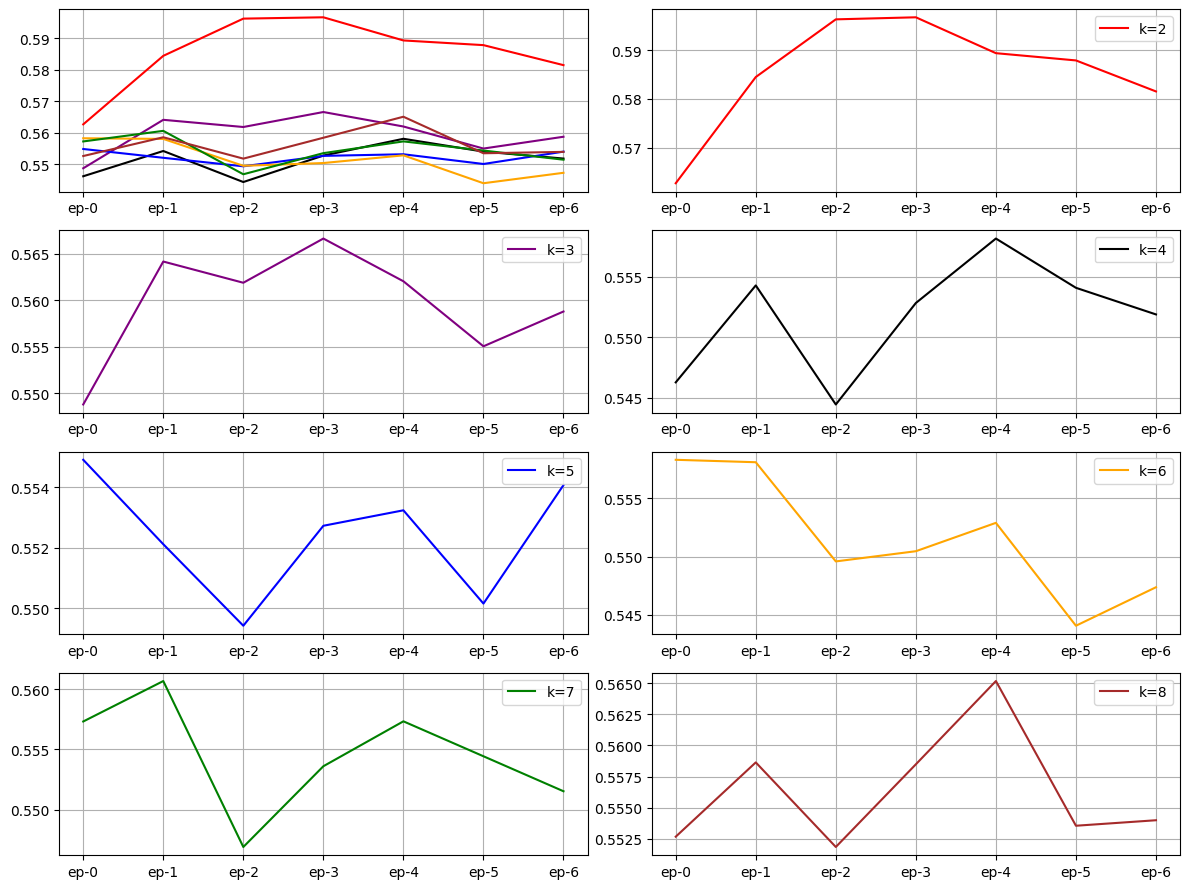

In [50]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 9))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")

ax2.grid(axis='both')
ax2.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax6.legend()

ax7.grid(axis='both')
ax7.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax7.legend()

ax8.grid(axis='both')
ax8.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")
ax8.legend()


fig.tight_layout()
fig.show()

In [51]:
cluster_table = PrettyTable()
cluster_table.field_names = ["Target", "Ideal Nr of Clusters per Epoch", "Score"]
for word in test_dict.keys():
  cluster_table.add_row([word, [x[0] for x in ideal_cluster_dict[word][2]], ["%.3f"%x[1] for x in ideal_cluster_dict[word][2]]])

print(cluster_table)

+--------------+--------------------------------+-----------------------------------------------------------------+
|    Target    | Ideal Nr of Clusters per Epoch |                              Score                              |
+--------------+--------------------------------+-----------------------------------------------------------------+
|   removes    |     [4, 8, 8, 8, 7, 5, 7]      | ['0.601', '0.582', '0.538', '0.588', '0.578', '0.580', '0.607'] |
|   lowland    |     [2, 2, 3, 2, 2, 2, 2]      | ['0.581', '0.630', '0.629', '0.607', '0.604', '0.598', '0.595'] |
|  accustomed  |     [2, 3, 8, 2, 2, 2, 7]      | ['0.557', '0.569', '0.587', '0.603', '0.644', '0.616', '0.593'] |
|   refuted    |     [2, 4, 2, 2, 7, 2, 3]      | ['0.607', '0.624', '0.589', '0.627', '0.607', '0.587', '0.565'] |
|   wetland    |     [8, 3, 2, 2, 8, 2, 5]      | ['0.581', '0.569', '0.578', '0.603', '0.611', '0.589', '0.591'] |
|    wrong     |     [7, 4, 2, 2, 2, 7, 2]      | ['0.621', '0.578', '0.

# Instead of "Context Word" Projections, Visualize "Context" Projections

In the plot below, for each given target word vector, the marks represent the average projection of context embeddings of each context.

In other words, one scatter represents the average projection of all the sorrounding words for one occurance of the target word.

In [52]:
context_dict = {x : list() for x in test_words}
window_size = 3

for idx, w in enumerate(words):
  if w in test_words:
    start , end = max(0 , idx-window_size) , min(len(words)-1 , idx+window_size) + 1
    ctx_samples = [s for s in words[start:idx] + words[idx+1:end] if s != w]
    context_dict[w].append(ctx_samples)

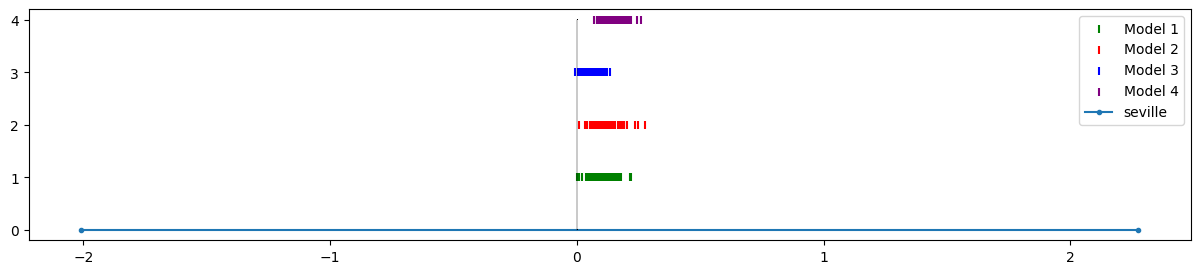

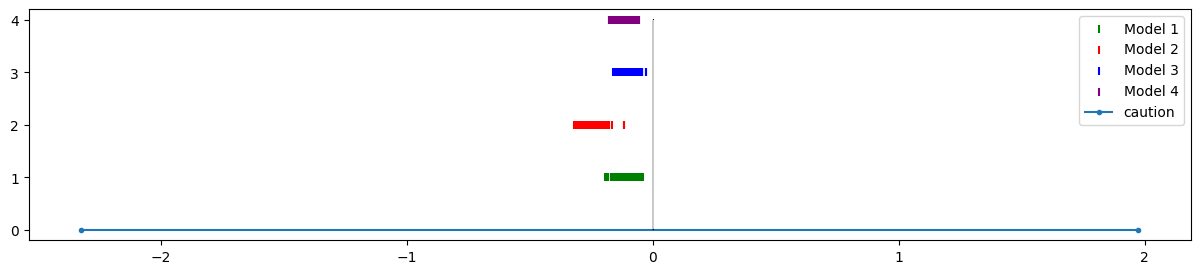

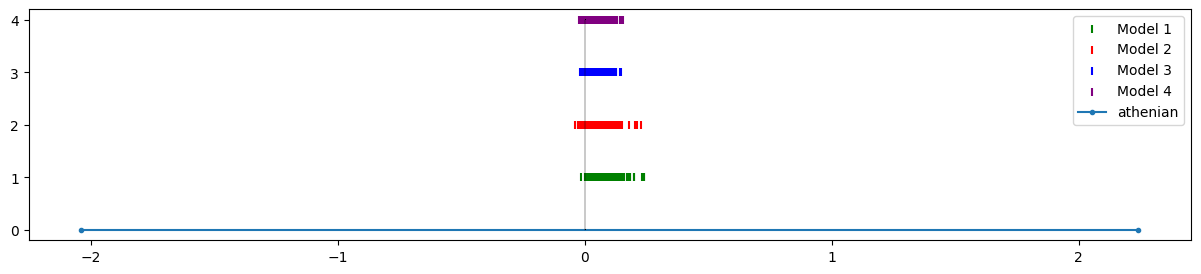

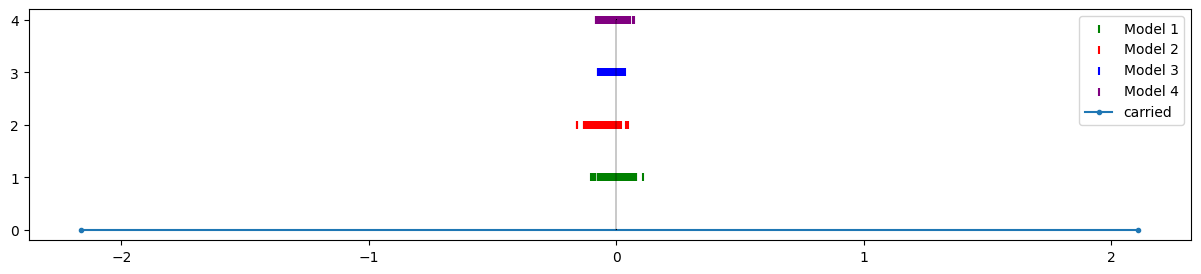

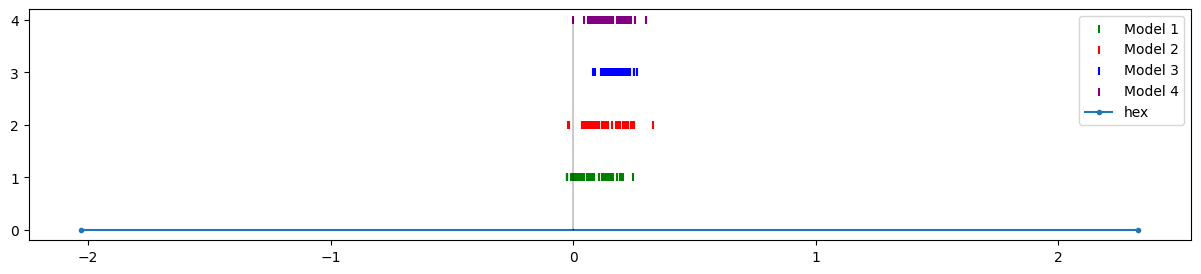

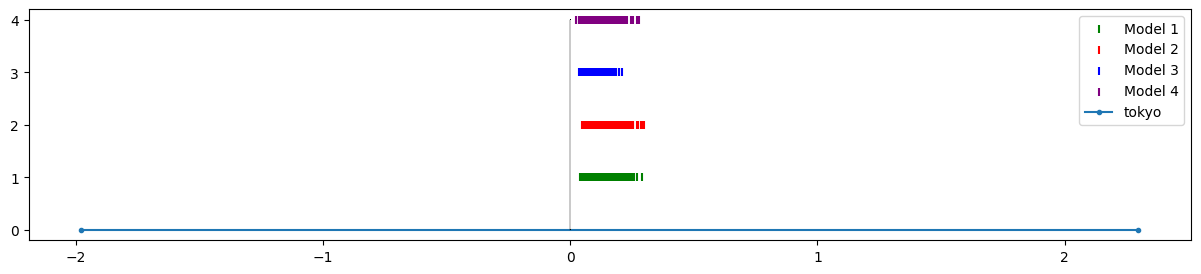

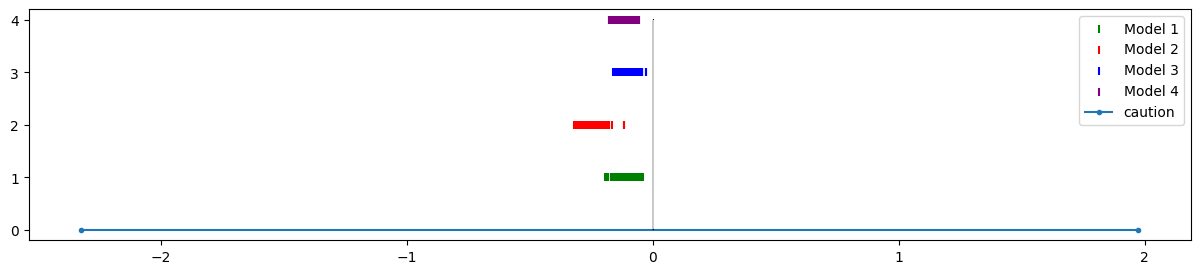

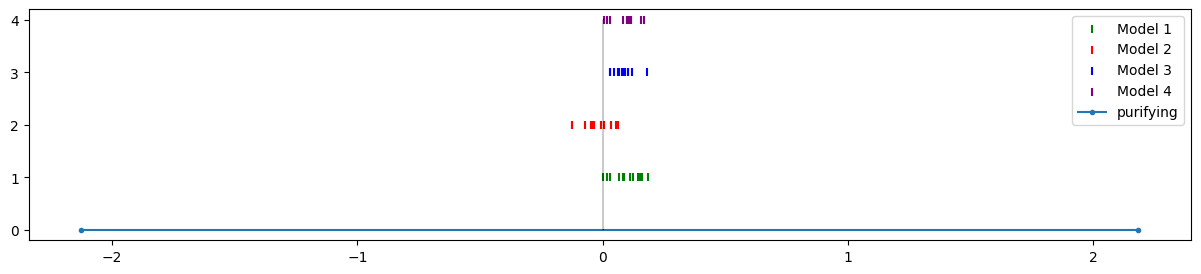

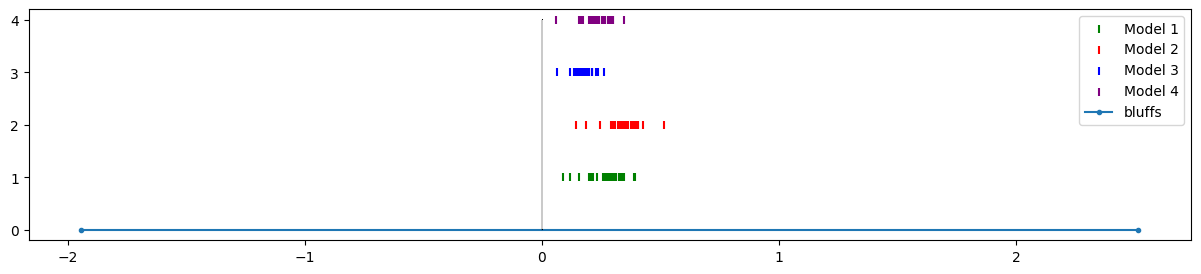

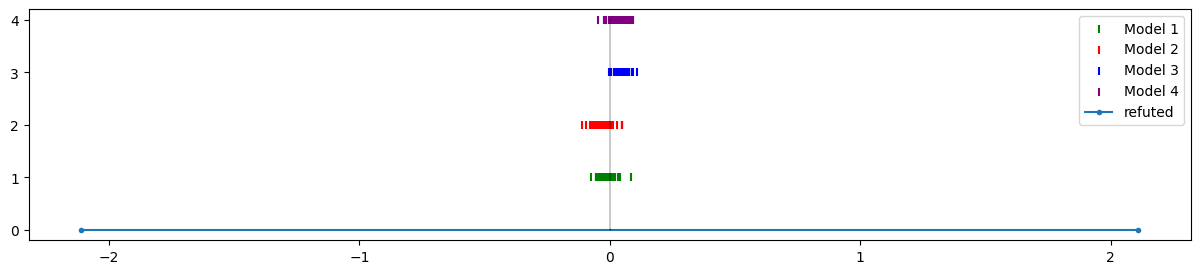

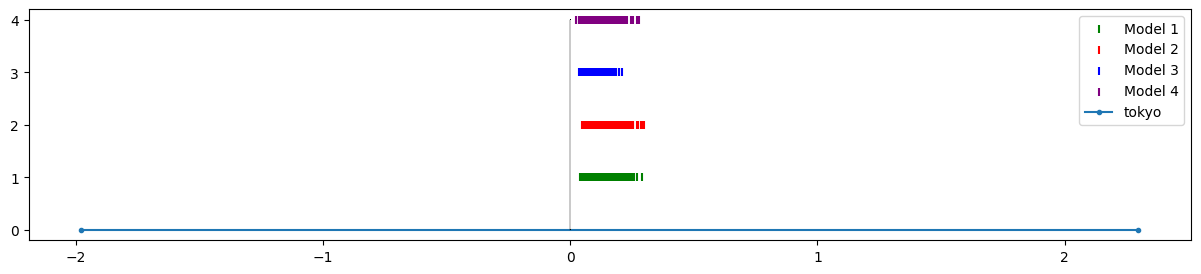

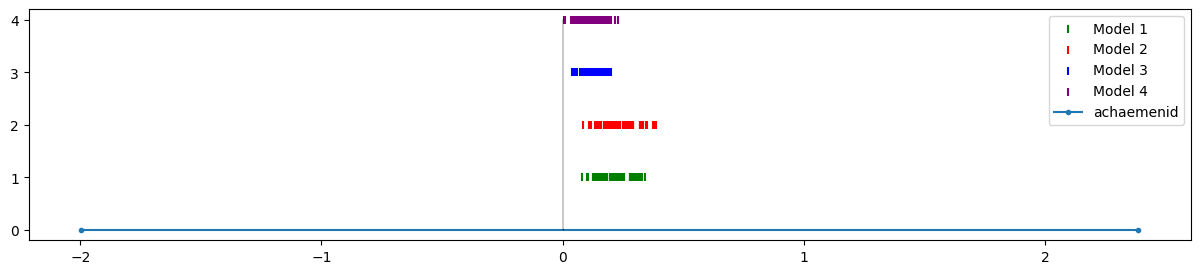

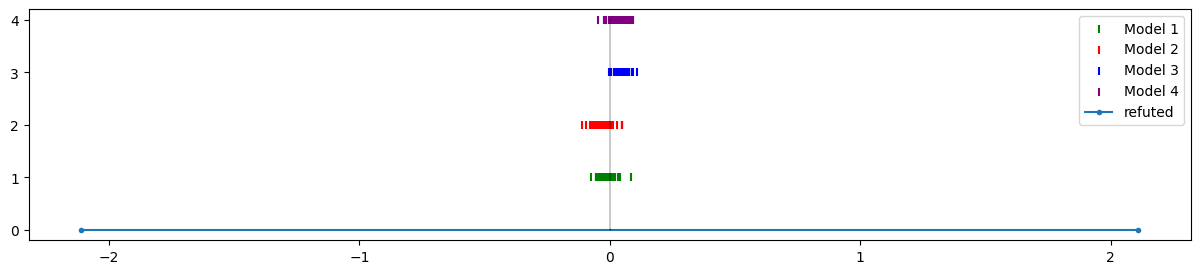

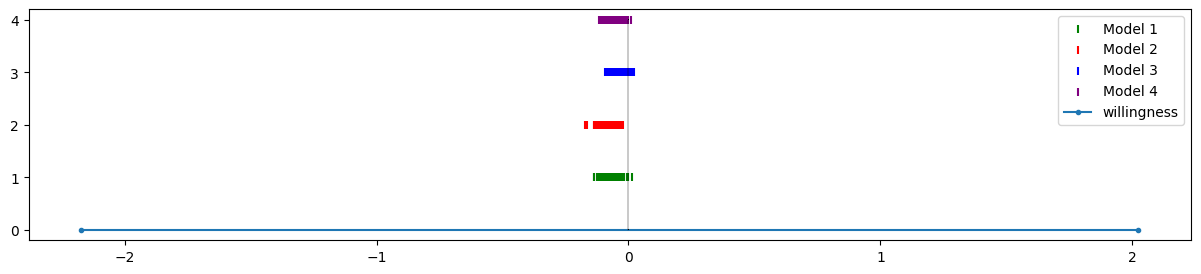

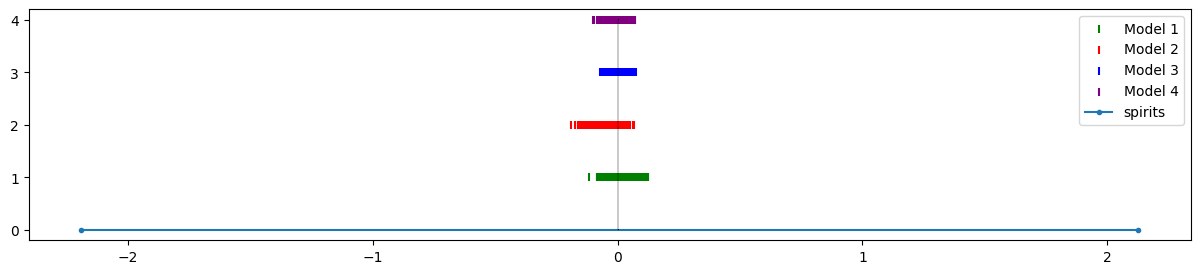

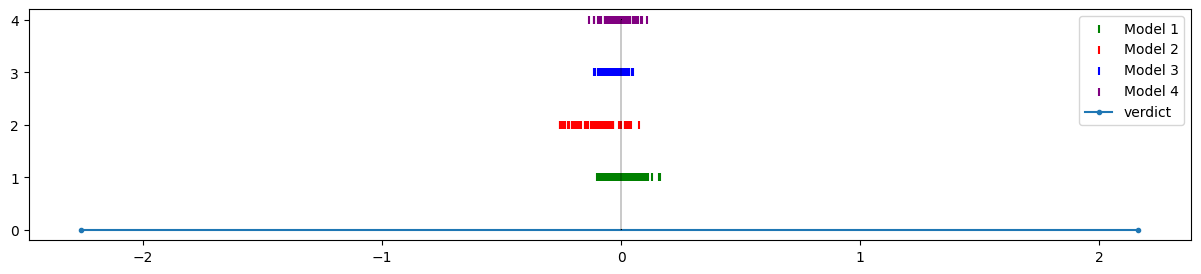

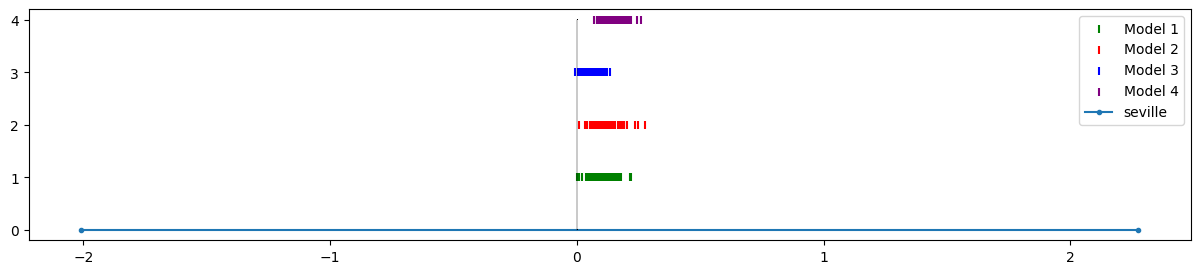

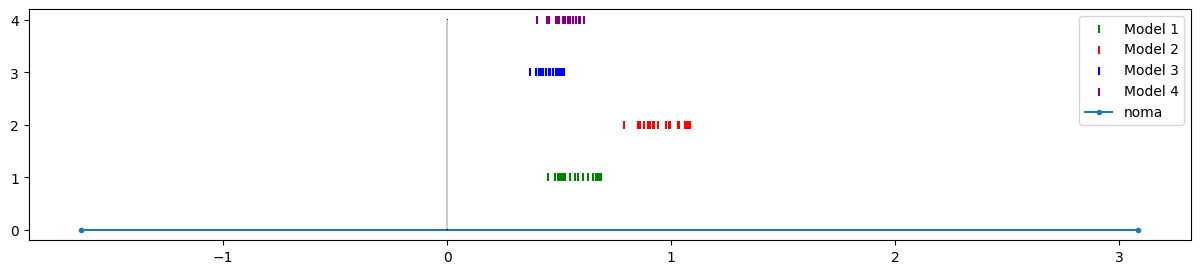

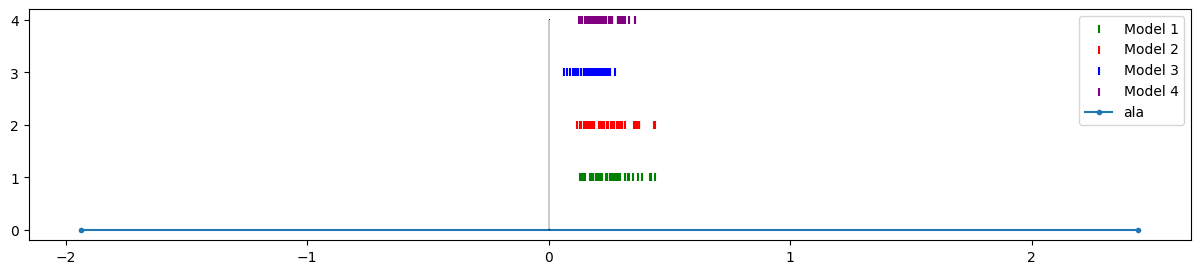

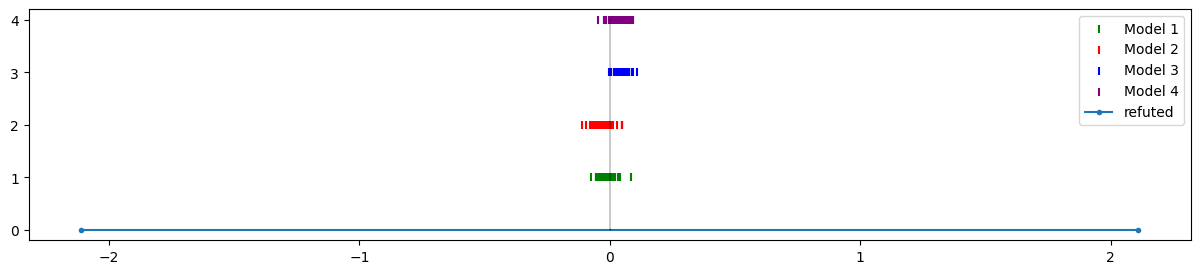

In [53]:
trgs = np.random.choice(list(context_dict.keys()), size=(20))

for trg in trgs:
  mins, maxes = list(), list()
  plt.figure(figsize=(15,3))

  contexts1 = get_context_projections(models1[-1], context_dict, trg)
  mins.append(min(contexts1))
  maxes.append(max(contexts1))
  plt.scatter(contexts1, [1] * len(contexts1), marker = '|', color="green", label="Model 1")

  contexts2 = get_context_projections(models2[-1], context_dict, trg)
  mins.append(min(contexts2))
  maxes.append(max(contexts2))
  plt.scatter(contexts2, [2] * len(contexts2), marker = '|', color="red", label="Model 2")

  contexts3 = get_context_projections(models3[-1], context_dict, trg)
  mins.append(min(contexts3))
  maxes.append(max(contexts3))
  plt.scatter(contexts3, [3] * len(contexts3), marker = '|', color="blue", label="Model 3")

  contexts4 = get_context_projections(models4[-1], context_dict, trg)
  mins.append(min(contexts4))
  maxes.append(max(contexts4))
  plt.scatter(contexts4, [4] * len(contexts4), marker = '|', color="purple", label="Model 4")

  #magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
  x1, y1 = [min(mins)-2, max(maxes)+2], [0, 0]
  plt.plot(x1, y1, marker = '.', label=trg)

  x1, y1 = [0, 0], [0, 4]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

  plt.legend()
  plt.show()

# DC

In [54]:
from google.colab import runtime
runtime.unassign()